In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 40
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_glcm_JointEntropy_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortRunLowGrayLevelEmphasis_glrlm_ShortRunHighGrayLevelEmphasis_glrlm_LongRunLowGrayLevelEmphasis_glrlm_LongRunHighGrayLevelEmphasis_ngtdm_Coarseness_ngtdm_

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 468)
(772408, 8)
validation
(101248, 468)
(101248, 8)
test
(98888, 468)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 468)]             0         


 dense (Dense)               (None, 1024)              480256    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1170312 (4.46 MB)


Trainable params: 1170312 (4.46 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:38 - loss: 2.3184 - STD: 0.0944 - MAE: 0.2242

 5/78 [>.............................] - ETA: 1s - loss: 1.6594 - STD: 0.1470 - MAE: 0.1736  

 7/78 [=>............................] - ETA: 1s - loss: 1.5815 - STD: 0.1749 - MAE: 0.1599

 9/78 [==>...........................] - ETA: 1s - loss: 1.5329 - STD: 0.1882 - MAE: 0.1532

11/78 [===>..........................] - ETA: 1s - loss: 1.5011 - STD: 0.1916 - MAE: 0.1509

13/78 [====>.........................] - ETA: 1s - loss: 1.4751 - STD: 0.1900 - MAE: 0.1507

15/78 [====>.........................] - ETA: 1s - loss: 1.4613 - STD: 0.1873 - MAE: 0.1514

17/78 [=====>........................] - ETA: 1s - loss: 1.4458 - STD: 0.1857 - MAE: 0.1515

19/78 [======>.......................] - ETA: 1s - loss: 1.4340 - STD: 0.1856 - MAE: 0.1512

21/78 [=======>......................] - ETA: 1s - loss: 1.4243 - STD: 0.1868 - MAE: 0.1504

23/78 [=======>......................] - ETA: 3s - loss: 1.4194 - STD: 0.1886 - MAE: 0.1494

28/78 [=========>....................] - ETA: 2s - loss: 1.4029 - STD: 0.1918 - MAE: 0.1477

30/78 [==========>...................] - ETA: 2s - loss: 1.3975 - STD: 0.1919 - MAE: 0.1475

32/78 [===========>..................] - ETA: 2s - loss: 1.3927 - STD: 0.1914 - MAE: 0.1476

34/78 [============>.................] - ETA: 1s - loss: 1.3877 - STD: 0.1908 - MAE: 0.1476

36/78 [============>.................] - ETA: 1s - loss: 1.3838 - STD: 0.1905 - MAE: 0.1477

38/78 [=============>................] - ETA: 1s - loss: 1.3805 - STD: 0.1904 - MAE: 0.1476

40/78 [==============>...............] - ETA: 1s - loss: 1.3779 - STD: 0.1907 - MAE: 0.1474

42/78 [===============>..............] - ETA: 1s - loss: 1.3750 - STD: 0.1911 - MAE: 0.1472

44/78 [===============>..............] - ETA: 1s - loss: 1.3715 - STD: 0.1915 - MAE: 0.1469

46/78 [================>.............] - ETA: 1s - loss: 1.3689 - STD: 0.1917 - MAE: 0.1467

48/78 [=================>............] - ETA: 1s - loss: 1.3666 - STD: 0.1917 - MAE: 0.1467

50/78 [==================>...........] - ETA: 1s - loss: 1.3648 - STD: 0.1916 - MAE: 0.1467

52/78 [===================>..........] - ETA: 1s - loss: 1.3633 - STD: 0.1914 - MAE: 0.1467

54/78 [===================>..........] - ETA: 0s - loss: 1.3606 - STD: 0.1913 - MAE: 0.1467

56/78 [====================>.........] - ETA: 0s - loss: 1.3591 - STD: 0.1912 - MAE: 0.1466

58/78 [=====================>........] - ETA: 0s - loss: 1.3575 - STD: 0.1913 - MAE: 0.1466

60/78 [======================>.......] - ETA: 0s - loss: 1.3561 - STD: 0.1914 - MAE: 0.1465

62/78 [======================>.......] - ETA: 0s - loss: 1.3547 - STD: 0.1915 - MAE: 0.1464

64/78 [=======================>......] - ETA: 0s - loss: 1.3536 - STD: 0.1916 - MAE: 0.1464

66/78 [========================>.....] - ETA: 0s - loss: 1.3524 - STD: 0.1915 - MAE: 0.1464

68/78 [=========================>....] - ETA: 0s - loss: 1.3511 - STD: 0.1915 - MAE: 0.1463

70/78 [=========================>....] - ETA: 0s - loss: 1.3501 - STD: 0.1914 - MAE: 0.1463

72/78 [==========================>...] - ETA: 0s - loss: 1.3494 - STD: 0.1914 - MAE: 0.1463

74/78 [===========================>..] - ETA: 0s - loss: 1.3485 - STD: 0.1914 - MAE: 0.1463

76/78 [============================>.] - ETA: 0s - loss: 1.3475 - STD: 0.1914 - MAE: 0.1463

78/78 [==============================] - ETA: 0s - loss: 1.3469 - STD: 0.1914 - MAE: 0.1463

78/78 [==============================] - 5s 46ms/step - loss: 1.3469 - STD: 0.1914 - MAE: 0.1463 - val_loss: 1.2731 - val_STD: 0.1913 - val_MAE: 0.1451


Epoch 2/10000


 1/78 [..............................] - ETA: 4s - loss: 1.3340 - STD: 0.1913 - MAE: 0.1466

 3/78 [>.............................] - ETA: 2s - loss: 1.3278 - STD: 0.1905 - MAE: 0.1462

 5/78 [>.............................] - ETA: 2s - loss: 1.3212 - STD: 0.1903 - MAE: 0.1460

 7/78 [=>............................] - ETA: 2s - loss: 1.3215 - STD: 0.1906 - MAE: 0.1460

 9/78 [==>...........................] - ETA: 2s - loss: 1.3214 - STD: 0.1908 - MAE: 0.1459

11/78 [===>..........................] - ETA: 2s - loss: 1.3209 - STD: 0.1909 - MAE: 0.1458

13/78 [====>.........................] - ETA: 2s - loss: 1.3190 - STD: 0.1909 - MAE: 0.1457

15/78 [====>.........................] - ETA: 2s - loss: 1.3180 - STD: 0.1909 - MAE: 0.1457

17/78 [=====>........................] - ETA: 2s - loss: 1.3165 - STD: 0.1909 - MAE: 0.1456

19/78 [======>.......................] - ETA: 1s - loss: 1.3162 - STD: 0.1910 - MAE: 0.1456

21/78 [=======>......................] - ETA: 1s - loss: 1.3156 - STD: 0.1911 - MAE: 0.1455

23/78 [=======>......................] - ETA: 1s - loss: 1.3152 - STD: 0.1911 - MAE: 0.1455

25/78 [========>.....................] - ETA: 1s - loss: 1.3147 - STD: 0.1911 - MAE: 0.1455

27/78 [=========>....................] - ETA: 1s - loss: 1.3145 - STD: 0.1911 - MAE: 0.1455

29/78 [==========>...................] - ETA: 1s - loss: 1.3139 - STD: 0.1911 - MAE: 0.1454

32/78 [===========>..................] - ETA: 1s - loss: 1.3128 - STD: 0.1911 - MAE: 0.1454

34/78 [============>.................] - ETA: 1s - loss: 1.3121 - STD: 0.1913 - MAE: 0.1453

36/78 [============>.................] - ETA: 1s - loss: 1.3121 - STD: 0.1915 - MAE: 0.1452

38/78 [=============>................] - ETA: 1s - loss: 1.3112 - STD: 0.1916 - MAE: 0.1451

40/78 [==============>...............] - ETA: 1s - loss: 1.3102 - STD: 0.1916 - MAE: 0.1450

42/78 [===============>..............] - ETA: 1s - loss: 1.3098 - STD: 0.1915 - MAE: 0.1450

44/78 [===============>..............] - ETA: 1s - loss: 1.3095 - STD: 0.1914 - MAE: 0.1450

46/78 [================>.............] - ETA: 1s - loss: 1.3088 - STD: 0.1914 - MAE: 0.1450

48/78 [=================>............] - ETA: 0s - loss: 1.3078 - STD: 0.1915 - MAE: 0.1449

50/78 [==================>...........] - ETA: 0s - loss: 1.3073 - STD: 0.1915 - MAE: 0.1449

52/78 [===================>..........] - ETA: 0s - loss: 1.3063 - STD: 0.1915 - MAE: 0.1448

54/78 [===================>..........] - ETA: 0s - loss: 1.3054 - STD: 0.1916 - MAE: 0.1447

56/78 [====================>.........] - ETA: 0s - loss: 1.3043 - STD: 0.1917 - MAE: 0.1446

58/78 [=====================>........] - ETA: 0s - loss: 1.3034 - STD: 0.1918 - MAE: 0.1446

60/78 [======================>.......] - ETA: 0s - loss: 1.3023 - STD: 0.1918 - MAE: 0.1445

62/78 [======================>.......] - ETA: 0s - loss: 1.3014 - STD: 0.1918 - MAE: 0.1445

64/78 [=======================>......] - ETA: 0s - loss: 1.3004 - STD: 0.1918 - MAE: 0.1444

66/78 [========================>.....] - ETA: 0s - loss: 1.2993 - STD: 0.1920 - MAE: 0.1443

68/78 [=========================>....] - ETA: 0s - loss: 1.2983 - STD: 0.1921 - MAE: 0.1442

70/78 [=========================>....] - ETA: 0s - loss: 1.2974 - STD: 0.1922 - MAE: 0.1441

72/78 [==========================>...] - ETA: 0s - loss: 1.2959 - STD: 0.1923 - MAE: 0.1440

74/78 [===========================>..] - ETA: 0s - loss: 1.2946 - STD: 0.1925 - MAE: 0.1439

76/78 [============================>.] - ETA: 0s - loss: 1.2935 - STD: 0.1925 - MAE: 0.1438

78/78 [==============================] - ETA: 0s - loss: 1.2925 - STD: 0.1927 - MAE: 0.1438

78/78 [==============================] - 3s 36ms/step - loss: 1.2925 - STD: 0.1927 - MAE: 0.1438 - val_loss: 1.1989 - val_STD: 0.2042 - val_MAE: 0.1364


Epoch 3/10000


 1/78 [..............................] - ETA: 5s - loss: 1.2476 - STD: 0.2035 - MAE: 0.1380

 3/78 [>.............................] - ETA: 2s - loss: 1.2382 - STD: 0.1982 - MAE: 0.1396

 5/78 [>.............................] - ETA: 2s - loss: 1.2400 - STD: 0.1968 - MAE: 0.1403

 7/78 [=>............................] - ETA: 2s - loss: 1.2376 - STD: 0.1973 - MAE: 0.1400

 9/78 [==>...........................] - ETA: 2s - loss: 1.2343 - STD: 0.1974 - MAE: 0.1398

11/78 [===>..........................] - ETA: 2s - loss: 1.2317 - STD: 0.1979 - MAE: 0.1396

13/78 [====>.........................] - ETA: 2s - loss: 1.2266 - STD: 0.1986 - MAE: 0.1390

15/78 [====>.........................] - ETA: 2s - loss: 1.2245 - STD: 0.1989 - MAE: 0.1389

17/78 [=====>........................] - ETA: 2s - loss: 1.2238 - STD: 0.1989 - MAE: 0.1389

19/78 [======>.......................] - ETA: 1s - loss: 1.2214 - STD: 0.1988 - MAE: 0.1389

21/78 [=======>......................] - ETA: 1s - loss: 1.2186 - STD: 0.1987 - MAE: 0.1388

23/78 [=======>......................] - ETA: 1s - loss: 1.2162 - STD: 0.1988 - MAE: 0.1387

25/78 [========>.....................] - ETA: 1s - loss: 1.2147 - STD: 0.1995 - MAE: 0.1384

27/78 [=========>....................] - ETA: 1s - loss: 1.2129 - STD: 0.1995 - MAE: 0.1383

29/78 [==========>...................] - ETA: 1s - loss: 1.2106 - STD: 0.1995 - MAE: 0.1382

31/78 [==========>...................] - ETA: 1s - loss: 1.2089 - STD: 0.1994 - MAE: 0.1382

33/78 [===========>..................] - ETA: 1s - loss: 1.2073 - STD: 0.1996 - MAE: 0.1381

35/78 [============>.................] - ETA: 1s - loss: 1.2054 - STD: 0.1998 - MAE: 0.1380

37/78 [=============>................] - ETA: 1s - loss: 1.2044 - STD: 0.1997 - MAE: 0.1380

39/78 [==============>...............] - ETA: 1s - loss: 1.2030 - STD: 0.1997 - MAE: 0.1380

41/78 [==============>...............] - ETA: 1s - loss: 1.2004 - STD: 0.1995 - MAE: 0.1380

43/78 [===============>..............] - ETA: 1s - loss: 1.1983 - STD: 0.2001 - MAE: 0.1377

45/78 [================>.............] - ETA: 1s - loss: 1.1964 - STD: 0.2002 - MAE: 0.1376

47/78 [=================>............] - ETA: 1s - loss: 1.1948 - STD: 0.2001 - MAE: 0.1376

49/78 [=================>............] - ETA: 0s - loss: 1.1929 - STD: 0.2001 - MAE: 0.1376

51/78 [==================>...........] - ETA: 0s - loss: 1.1906 - STD: 0.2003 - MAE: 0.1374

53/78 [===================>..........] - ETA: 0s - loss: 1.1893 - STD: 0.2006 - MAE: 0.1373

55/78 [====================>.........] - ETA: 0s - loss: 1.1875 - STD: 0.2004 - MAE: 0.1373

57/78 [====================>.........] - ETA: 0s - loss: 1.1858 - STD: 0.2005 - MAE: 0.1373

59/78 [=====================>........] - ETA: 0s - loss: 1.1845 - STD: 0.2006 - MAE: 0.1372

61/78 [======================>.......] - ETA: 0s - loss: 1.1826 - STD: 0.2007 - MAE: 0.1371

63/78 [=======================>......] - ETA: 0s - loss: 1.1805 - STD: 0.2007 - MAE: 0.1370

65/78 [========================>.....] - ETA: 0s - loss: 1.1792 - STD: 0.2008 - MAE: 0.1370

67/78 [========================>.....] - ETA: 0s - loss: 1.1776 - STD: 0.2008 - MAE: 0.1370

69/78 [=========================>....] - ETA: 0s - loss: 1.1760 - STD: 0.2008 - MAE: 0.1369

71/78 [==========================>...] - ETA: 0s - loss: 1.1745 - STD: 0.2009 - MAE: 0.1368

73/78 [===========================>..] - ETA: 0s - loss: 1.1728 - STD: 0.2009 - MAE: 0.1368

75/78 [===========================>..] - ETA: 0s - loss: 1.1711 - STD: 0.2009 - MAE: 0.1367

78/78 [==============================] - ETA: 0s - loss: 1.1691 - STD: 0.2009 - MAE: 0.1367

78/78 [==============================] - 3s 35ms/step - loss: 1.1691 - STD: 0.2009 - MAE: 0.1367 - val_loss: 1.0766 - val_STD: 0.2070 - val_MAE: 0.1311


Epoch 4/10000


 1/78 [..............................] - ETA: 4s - loss: 1.0685 - STD: 0.2058 - MAE: 0.1313

 3/78 [>.............................] - ETA: 2s - loss: 1.0750 - STD: 0.2097 - MAE: 0.1300

 5/78 [>.............................] - ETA: 2s - loss: 1.0823 - STD: 0.2052 - MAE: 0.1322

 7/78 [=>............................] - ETA: 2s - loss: 1.0824 - STD: 0.2065 - MAE: 0.1316

 9/78 [==>...........................] - ETA: 2s - loss: 1.0821 - STD: 0.2066 - MAE: 0.1317

11/78 [===>..........................] - ETA: 2s - loss: 1.0791 - STD: 0.2061 - MAE: 0.1316

13/78 [====>.........................] - ETA: 2s - loss: 1.0778 - STD: 0.2076 - MAE: 0.1310

15/78 [====>.........................] - ETA: 2s - loss: 1.0777 - STD: 0.2063 - MAE: 0.1315

17/78 [=====>........................] - ETA: 2s - loss: 1.0773 - STD: 0.2071 - MAE: 0.1312

19/78 [======>.......................] - ETA: 1s - loss: 1.0745 - STD: 0.2071 - MAE: 0.1311

21/78 [=======>......................] - ETA: 1s - loss: 1.0728 - STD: 0.2073 - MAE: 0.1310

23/78 [=======>......................] - ETA: 1s - loss: 1.0712 - STD: 0.2078 - MAE: 0.1307

25/78 [========>.....................] - ETA: 1s - loss: 1.0695 - STD: 0.2076 - MAE: 0.1306

27/78 [=========>....................] - ETA: 1s - loss: 1.0671 - STD: 0.2082 - MAE: 0.1303

29/78 [==========>...................] - ETA: 1s - loss: 1.0659 - STD: 0.2081 - MAE: 0.1303

31/78 [==========>...................] - ETA: 1s - loss: 1.0650 - STD: 0.2085 - MAE: 0.1301

33/78 [===========>..................] - ETA: 1s - loss: 1.0632 - STD: 0.2085 - MAE: 0.1300

35/78 [============>.................] - ETA: 1s - loss: 1.0621 - STD: 0.2087 - MAE: 0.1299

37/78 [=============>................] - ETA: 1s - loss: 1.0607 - STD: 0.2088 - MAE: 0.1297

39/78 [==============>...............] - ETA: 1s - loss: 1.0596 - STD: 0.2090 - MAE: 0.1296

41/78 [==============>...............] - ETA: 1s - loss: 1.0581 - STD: 0.2092 - MAE: 0.1295

43/78 [===============>..............] - ETA: 1s - loss: 1.0569 - STD: 0.2092 - MAE: 0.1294

45/78 [================>.............] - ETA: 1s - loss: 1.0554 - STD: 0.2095 - MAE: 0.1292

47/78 [=================>............] - ETA: 1s - loss: 1.0546 - STD: 0.2095 - MAE: 0.1292

49/78 [=================>............] - ETA: 0s - loss: 1.0538 - STD: 0.2097 - MAE: 0.1291

51/78 [==================>...........] - ETA: 0s - loss: 1.0530 - STD: 0.2097 - MAE: 0.1290

53/78 [===================>..........] - ETA: 0s - loss: 1.0517 - STD: 0.2098 - MAE: 0.1289

55/78 [====================>.........] - ETA: 0s - loss: 1.0505 - STD: 0.2100 - MAE: 0.1288

57/78 [====================>.........] - ETA: 0s - loss: 1.0495 - STD: 0.2100 - MAE: 0.1288

59/78 [=====================>........] - ETA: 0s - loss: 1.0482 - STD: 0.2103 - MAE: 0.1286

61/78 [======================>.......] - ETA: 0s - loss: 1.0473 - STD: 0.2103 - MAE: 0.1286

63/78 [=======================>......] - ETA: 0s - loss: 1.0466 - STD: 0.2104 - MAE: 0.1285

65/78 [========================>.....] - ETA: 0s - loss: 1.0456 - STD: 0.2105 - MAE: 0.1284

67/78 [========================>.....] - ETA: 0s - loss: 1.0446 - STD: 0.2106 - MAE: 0.1284

69/78 [=========================>....] - ETA: 0s - loss: 1.0436 - STD: 0.2107 - MAE: 0.1283

72/78 [==========================>...] - ETA: 0s - loss: 1.0424 - STD: 0.2110 - MAE: 0.1281

74/78 [===========================>..] - ETA: 0s - loss: 1.0412 - STD: 0.2110 - MAE: 0.1280

76/78 [============================>.] - ETA: 0s - loss: 1.0406 - STD: 0.2111 - MAE: 0.1280

78/78 [==============================] - ETA: 0s - loss: 1.0397 - STD: 0.2112 - MAE: 0.1279

78/78 [==============================] - 3s 35ms/step - loss: 1.0397 - STD: 0.2112 - MAE: 0.1279 - val_loss: 1.0106 - val_STD: 0.2103 - val_MAE: 0.1268


Epoch 5/10000


 1/78 [..............................] - ETA: 4s - loss: 0.9859 - STD: 0.2148 - MAE: 0.1240

 3/78 [>.............................] - ETA: 2s - loss: 0.9954 - STD: 0.2166 - MAE: 0.1238

 5/78 [>.............................] - ETA: 2s - loss: 0.9958 - STD: 0.2162 - MAE: 0.1238

 7/78 [=>............................] - ETA: 2s - loss: 0.9944 - STD: 0.2158 - MAE: 0.1240

 9/78 [==>...........................] - ETA: 2s - loss: 0.9951 - STD: 0.2162 - MAE: 0.1239

11/78 [===>..........................] - ETA: 2s - loss: 0.9928 - STD: 0.2158 - MAE: 0.1240

13/78 [====>.........................] - ETA: 2s - loss: 0.9929 - STD: 0.2159 - MAE: 0.1239

15/78 [====>.........................] - ETA: 2s - loss: 0.9907 - STD: 0.2168 - MAE: 0.1235

17/78 [=====>........................] - ETA: 2s - loss: 0.9904 - STD: 0.2161 - MAE: 0.1237

19/78 [======>.......................] - ETA: 1s - loss: 0.9886 - STD: 0.2164 - MAE: 0.1235

21/78 [=======>......................] - ETA: 1s - loss: 0.9869 - STD: 0.2167 - MAE: 0.1233

23/78 [=======>......................] - ETA: 1s - loss: 0.9859 - STD: 0.2166 - MAE: 0.1234

25/78 [========>.....................] - ETA: 1s - loss: 0.9850 - STD: 0.2167 - MAE: 0.1233

27/78 [=========>....................] - ETA: 1s - loss: 0.9835 - STD: 0.2169 - MAE: 0.1231

29/78 [==========>...................] - ETA: 1s - loss: 0.9815 - STD: 0.2171 - MAE: 0.1229

31/78 [==========>...................] - ETA: 1s - loss: 0.9808 - STD: 0.2168 - MAE: 0.1231

33/78 [===========>..................] - ETA: 1s - loss: 0.9787 - STD: 0.2172 - MAE: 0.1228

35/78 [============>.................] - ETA: 1s - loss: 0.9781 - STD: 0.2172 - MAE: 0.1228

37/78 [=============>................] - ETA: 1s - loss: 0.9769 - STD: 0.2171 - MAE: 0.1228

39/78 [==============>...............] - ETA: 1s - loss: 0.9759 - STD: 0.2173 - MAE: 0.1227

41/78 [==============>...............] - ETA: 1s - loss: 0.9744 - STD: 0.2173 - MAE: 0.1226

43/78 [===============>..............] - ETA: 1s - loss: 0.9732 - STD: 0.2175 - MAE: 0.1225

45/78 [================>.............] - ETA: 1s - loss: 0.9719 - STD: 0.2176 - MAE: 0.1224

47/78 [=================>............] - ETA: 1s - loss: 0.9708 - STD: 0.2177 - MAE: 0.1223

49/78 [=================>............] - ETA: 0s - loss: 0.9693 - STD: 0.2179 - MAE: 0.1222

51/78 [==================>...........] - ETA: 0s - loss: 0.9678 - STD: 0.2179 - MAE: 0.1221

53/78 [===================>..........] - ETA: 0s - loss: 0.9665 - STD: 0.2182 - MAE: 0.1219

55/78 [====================>.........] - ETA: 0s - loss: 0.9656 - STD: 0.2182 - MAE: 0.1219

57/78 [====================>.........] - ETA: 0s - loss: 0.9644 - STD: 0.2183 - MAE: 0.1217

59/78 [=====================>........] - ETA: 0s - loss: 0.9631 - STD: 0.2185 - MAE: 0.1216

61/78 [======================>.......] - ETA: 0s - loss: 0.9616 - STD: 0.2185 - MAE: 0.1215

63/78 [=======================>......] - ETA: 0s - loss: 0.9608 - STD: 0.2187 - MAE: 0.1214

65/78 [========================>.....] - ETA: 0s - loss: 0.9598 - STD: 0.2189 - MAE: 0.1213

67/78 [========================>.....] - ETA: 0s - loss: 0.9588 - STD: 0.2189 - MAE: 0.1212

69/78 [=========================>....] - ETA: 0s - loss: 0.9578 - STD: 0.2191 - MAE: 0.1211

71/78 [==========================>...] - ETA: 0s - loss: 0.9566 - STD: 0.2192 - MAE: 0.1210

73/78 [===========================>..] - ETA: 0s - loss: 0.9556 - STD: 0.2194 - MAE: 0.1209

76/78 [============================>.] - ETA: 0s - loss: 0.9547 - STD: 0.2195 - MAE: 0.1208

78/78 [==============================] - ETA: 0s - loss: 0.9537 - STD: 0.2196 - MAE: 0.1207

78/78 [==============================] - 3s 35ms/step - loss: 0.9537 - STD: 0.2196 - MAE: 0.1207 - val_loss: 0.9155 - val_STD: 0.2182 - val_MAE: 0.1196


Epoch 6/10000


 1/78 [..............................] - ETA: 4s - loss: 0.9108 - STD: 0.2197 - MAE: 0.1188

 3/78 [>.............................] - ETA: 2s - loss: 0.9166 - STD: 0.2231 - MAE: 0.1176

 5/78 [>.............................] - ETA: 2s - loss: 0.9119 - STD: 0.2237 - MAE: 0.1170

 7/78 [=>............................] - ETA: 2s - loss: 0.9151 - STD: 0.2230 - MAE: 0.1175

 9/78 [==>...........................] - ETA: 2s - loss: 0.9144 - STD: 0.2243 - MAE: 0.1169

11/78 [===>..........................] - ETA: 2s - loss: 0.9158 - STD: 0.2242 - MAE: 0.1170

13/78 [====>.........................] - ETA: 2s - loss: 0.9153 - STD: 0.2238 - MAE: 0.1172

15/78 [====>.........................] - ETA: 2s - loss: 0.9164 - STD: 0.2238 - MAE: 0.1172

17/78 [=====>........................] - ETA: 2s - loss: 0.9171 - STD: 0.2240 - MAE: 0.1172

19/78 [======>.......................] - ETA: 1s - loss: 0.9158 - STD: 0.2240 - MAE: 0.1171

21/78 [=======>......................] - ETA: 1s - loss: 0.9146 - STD: 0.2239 - MAE: 0.1171

24/78 [========>.....................] - ETA: 1s - loss: 0.9142 - STD: 0.2240 - MAE: 0.1170

26/78 [=========>....................] - ETA: 1s - loss: 0.9128 - STD: 0.2244 - MAE: 0.1168

28/78 [=========>....................] - ETA: 1s - loss: 0.9123 - STD: 0.2243 - MAE: 0.1168

30/78 [==========>...................] - ETA: 1s - loss: 0.9123 - STD: 0.2242 - MAE: 0.1168

32/78 [===========>..................] - ETA: 1s - loss: 0.9116 - STD: 0.2247 - MAE: 0.1166

34/78 [============>.................] - ETA: 1s - loss: 0.9113 - STD: 0.2245 - MAE: 0.1167

36/78 [============>.................] - ETA: 1s - loss: 0.9117 - STD: 0.2246 - MAE: 0.1167

38/78 [=============>................] - ETA: 1s - loss: 0.9115 - STD: 0.2248 - MAE: 0.1166

40/78 [==============>...............] - ETA: 1s - loss: 0.9107 - STD: 0.2246 - MAE: 0.1166

42/78 [===============>..............] - ETA: 1s - loss: 0.9104 - STD: 0.2248 - MAE: 0.1165

44/78 [===============>..............] - ETA: 1s - loss: 0.9106 - STD: 0.2246 - MAE: 0.1167

46/78 [================>.............] - ETA: 1s - loss: 0.9101 - STD: 0.2249 - MAE: 0.1165

48/78 [=================>............] - ETA: 0s - loss: 0.9096 - STD: 0.2247 - MAE: 0.1166

50/78 [==================>...........] - ETA: 0s - loss: 0.9096 - STD: 0.2250 - MAE: 0.1165

52/78 [===================>..........] - ETA: 0s - loss: 0.9088 - STD: 0.2249 - MAE: 0.1165

54/78 [===================>..........] - ETA: 0s - loss: 0.9083 - STD: 0.2250 - MAE: 0.1164

56/78 [====================>.........] - ETA: 0s - loss: 0.9080 - STD: 0.2251 - MAE: 0.1163

58/78 [=====================>........] - ETA: 0s - loss: 0.9074 - STD: 0.2251 - MAE: 0.1163

60/78 [======================>.......] - ETA: 0s - loss: 0.9071 - STD: 0.2252 - MAE: 0.1162

62/78 [======================>.......] - ETA: 0s - loss: 0.9068 - STD: 0.2253 - MAE: 0.1162

64/78 [=======================>......] - ETA: 0s - loss: 0.9065 - STD: 0.2254 - MAE: 0.1161

66/78 [========================>.....] - ETA: 0s - loss: 0.9061 - STD: 0.2253 - MAE: 0.1161

68/78 [=========================>....] - ETA: 0s - loss: 0.9060 - STD: 0.2253 - MAE: 0.1161

70/78 [=========================>....] - ETA: 0s - loss: 0.9058 - STD: 0.2254 - MAE: 0.1161

72/78 [==========================>...] - ETA: 0s - loss: 0.9052 - STD: 0.2254 - MAE: 0.1160

74/78 [===========================>..] - ETA: 0s - loss: 0.9050 - STD: 0.2254 - MAE: 0.1160

76/78 [============================>.] - ETA: 0s - loss: 0.9045 - STD: 0.2256 - MAE: 0.1159

78/78 [==============================] - ETA: 0s - loss: 0.9042 - STD: 0.2256 - MAE: 0.1159

78/78 [==============================] - 3s 35ms/step - loss: 0.9042 - STD: 0.2256 - MAE: 0.1159 - val_loss: 0.8997 - val_STD: 0.2294 - val_MAE: 0.1137


Epoch 7/10000


 1/78 [..............................] - ETA: 4s - loss: 0.9010 - STD: 0.2317 - MAE: 0.1134

 3/78 [>.............................] - ETA: 2s - loss: 0.8911 - STD: 0.2268 - MAE: 0.1149

 5/78 [>.............................] - ETA: 2s - loss: 0.8993 - STD: 0.2263 - MAE: 0.1157

 7/78 [=>............................] - ETA: 2s - loss: 0.8982 - STD: 0.2276 - MAE: 0.1150

 9/78 [==>...........................] - ETA: 2s - loss: 0.8980 - STD: 0.2263 - MAE: 0.1155

11/78 [===>..........................] - ETA: 2s - loss: 0.8974 - STD: 0.2275 - MAE: 0.1149

13/78 [====>.........................] - ETA: 2s - loss: 0.8970 - STD: 0.2268 - MAE: 0.1152

15/78 [====>.........................] - ETA: 2s - loss: 0.8959 - STD: 0.2273 - MAE: 0.1149

17/78 [=====>........................] - ETA: 2s - loss: 0.8953 - STD: 0.2269 - MAE: 0.1150

19/78 [======>.......................] - ETA: 1s - loss: 0.8952 - STD: 0.2272 - MAE: 0.1148

21/78 [=======>......................] - ETA: 1s - loss: 0.8943 - STD: 0.2273 - MAE: 0.1147

23/78 [=======>......................] - ETA: 1s - loss: 0.8931 - STD: 0.2274 - MAE: 0.1146

25/78 [========>.....................] - ETA: 1s - loss: 0.8914 - STD: 0.2276 - MAE: 0.1144

27/78 [=========>....................] - ETA: 1s - loss: 0.8911 - STD: 0.2275 - MAE: 0.1145

29/78 [==========>...................] - ETA: 1s - loss: 0.8904 - STD: 0.2275 - MAE: 0.1145

31/78 [==========>...................] - ETA: 1s - loss: 0.8901 - STD: 0.2276 - MAE: 0.1144

33/78 [===========>..................] - ETA: 1s - loss: 0.8895 - STD: 0.2276 - MAE: 0.1143

35/78 [============>.................] - ETA: 1s - loss: 0.8898 - STD: 0.2275 - MAE: 0.1144

37/78 [=============>................] - ETA: 1s - loss: 0.8893 - STD: 0.2278 - MAE: 0.1143

39/78 [==============>...............] - ETA: 1s - loss: 0.8888 - STD: 0.2276 - MAE: 0.1143

41/78 [==============>...............] - ETA: 1s - loss: 0.8884 - STD: 0.2278 - MAE: 0.1142

43/78 [===============>..............] - ETA: 1s - loss: 0.8882 - STD: 0.2278 - MAE: 0.1142

45/78 [================>.............] - ETA: 1s - loss: 0.8877 - STD: 0.2278 - MAE: 0.1142

47/78 [=================>............] - ETA: 1s - loss: 0.8871 - STD: 0.2280 - MAE: 0.1141

49/78 [=================>............] - ETA: 0s - loss: 0.8873 - STD: 0.2278 - MAE: 0.1142

51/78 [==================>...........] - ETA: 0s - loss: 0.8868 - STD: 0.2278 - MAE: 0.1141

53/78 [===================>..........] - ETA: 0s - loss: 0.8862 - STD: 0.2278 - MAE: 0.1141

55/78 [====================>.........] - ETA: 0s - loss: 0.8860 - STD: 0.2279 - MAE: 0.1141

57/78 [====================>.........] - ETA: 0s - loss: 0.8859 - STD: 0.2279 - MAE: 0.1140

59/78 [=====================>........] - ETA: 0s - loss: 0.8855 - STD: 0.2279 - MAE: 0.1140

61/78 [======================>.......] - ETA: 0s - loss: 0.8854 - STD: 0.2280 - MAE: 0.1140

63/78 [=======================>......] - ETA: 0s - loss: 0.8852 - STD: 0.2280 - MAE: 0.1140

65/78 [========================>.....] - ETA: 0s - loss: 0.8851 - STD: 0.2280 - MAE: 0.1140

67/78 [========================>.....] - ETA: 0s - loss: 0.8855 - STD: 0.2280 - MAE: 0.1140

69/78 [=========================>....] - ETA: 0s - loss: 0.8851 - STD: 0.2280 - MAE: 0.1140

72/78 [==========================>...] - ETA: 0s - loss: 0.8847 - STD: 0.2280 - MAE: 0.1139

74/78 [===========================>..] - ETA: 0s - loss: 0.8846 - STD: 0.2281 - MAE: 0.1139

76/78 [============================>.] - ETA: 0s - loss: 0.8843 - STD: 0.2281 - MAE: 0.1139

78/78 [==============================] - ETA: 0s - loss: 0.8843 - STD: 0.2282 - MAE: 0.1139

78/78 [==============================] - 3s 34ms/step - loss: 0.8843 - STD: 0.2282 - MAE: 0.1139 - val_loss: 0.8759 - val_STD: 0.2266 - val_MAE: 0.1139


Epoch 8/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8826 - STD: 0.2287 - MAE: 0.1135

 3/78 [>.............................] - ETA: 2s - loss: 0.8809 - STD: 0.2315 - MAE: 0.1121

 5/78 [>.............................] - ETA: 2s - loss: 0.8866 - STD: 0.2290 - MAE: 0.1136

 8/78 [==>...........................] - ETA: 2s - loss: 0.8836 - STD: 0.2289 - MAE: 0.1134

10/78 [==>...........................] - ETA: 2s - loss: 0.8822 - STD: 0.2299 - MAE: 0.1130

12/78 [===>..........................] - ETA: 2s - loss: 0.8809 - STD: 0.2293 - MAE: 0.1132

14/78 [====>.........................] - ETA: 2s - loss: 0.8827 - STD: 0.2292 - MAE: 0.1133

16/78 [=====>........................] - ETA: 1s - loss: 0.8818 - STD: 0.2286 - MAE: 0.1135

18/78 [=====>........................] - ETA: 1s - loss: 0.8824 - STD: 0.2292 - MAE: 0.1133

20/78 [======>.......................] - ETA: 1s - loss: 0.8822 - STD: 0.2289 - MAE: 0.1135

22/78 [=======>......................] - ETA: 1s - loss: 0.8820 - STD: 0.2289 - MAE: 0.1135

24/78 [========>.....................] - ETA: 1s - loss: 0.8809 - STD: 0.2290 - MAE: 0.1134

26/78 [=========>....................] - ETA: 1s - loss: 0.8816 - STD: 0.2291 - MAE: 0.1134

28/78 [=========>....................] - ETA: 1s - loss: 0.8812 - STD: 0.2288 - MAE: 0.1135

30/78 [==========>...................] - ETA: 1s - loss: 0.8810 - STD: 0.2291 - MAE: 0.1134

32/78 [===========>..................] - ETA: 1s - loss: 0.8812 - STD: 0.2291 - MAE: 0.1134

34/78 [============>.................] - ETA: 1s - loss: 0.8799 - STD: 0.2291 - MAE: 0.1133

36/78 [============>.................] - ETA: 1s - loss: 0.8794 - STD: 0.2294 - MAE: 0.1131

38/78 [=============>................] - ETA: 1s - loss: 0.8793 - STD: 0.2292 - MAE: 0.1132

40/78 [==============>...............] - ETA: 1s - loss: 0.8787 - STD: 0.2293 - MAE: 0.1132

42/78 [===============>..............] - ETA: 1s - loss: 0.8788 - STD: 0.2293 - MAE: 0.1131

44/78 [===============>..............] - ETA: 1s - loss: 0.8781 - STD: 0.2293 - MAE: 0.1131

46/78 [================>.............] - ETA: 1s - loss: 0.8785 - STD: 0.2293 - MAE: 0.1132

48/78 [=================>............] - ETA: 0s - loss: 0.8780 - STD: 0.2293 - MAE: 0.1131

50/78 [==================>...........] - ETA: 0s - loss: 0.8780 - STD: 0.2292 - MAE: 0.1132

52/78 [===================>..........] - ETA: 0s - loss: 0.8778 - STD: 0.2294 - MAE: 0.1131

54/78 [===================>..........] - ETA: 0s - loss: 0.8778 - STD: 0.2293 - MAE: 0.1131

56/78 [====================>.........] - ETA: 0s - loss: 0.8776 - STD: 0.2294 - MAE: 0.1131

58/78 [=====================>........] - ETA: 0s - loss: 0.8768 - STD: 0.2294 - MAE: 0.1130

60/78 [======================>.......] - ETA: 0s - loss: 0.8765 - STD: 0.2294 - MAE: 0.1130

62/78 [======================>.......] - ETA: 0s - loss: 0.8764 - STD: 0.2295 - MAE: 0.1130

64/78 [=======================>......] - ETA: 0s - loss: 0.8762 - STD: 0.2294 - MAE: 0.1130

66/78 [========================>.....] - ETA: 0s - loss: 0.8759 - STD: 0.2295 - MAE: 0.1129

68/78 [=========================>....] - ETA: 0s - loss: 0.8754 - STD: 0.2294 - MAE: 0.1129

70/78 [=========================>....] - ETA: 0s - loss: 0.8748 - STD: 0.2296 - MAE: 0.1128

72/78 [==========================>...] - ETA: 0s - loss: 0.8742 - STD: 0.2295 - MAE: 0.1128

74/78 [===========================>..] - ETA: 0s - loss: 0.8740 - STD: 0.2296 - MAE: 0.1128

76/78 [============================>.] - ETA: 0s - loss: 0.8736 - STD: 0.2296 - MAE: 0.1128

78/78 [==============================] - ETA: 0s - loss: 0.8735 - STD: 0.2296 - MAE: 0.1127

78/78 [==============================] - 3s 34ms/step - loss: 0.8735 - STD: 0.2296 - MAE: 0.1127 - val_loss: 0.8769 - val_STD: 0.2240 - val_MAE: 0.1152


Epoch 9/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8626 - STD: 0.2275 - MAE: 0.1130

 3/78 [>.............................] - ETA: 2s - loss: 0.8617 - STD: 0.2323 - MAE: 0.1109

 5/78 [>.............................] - ETA: 2s - loss: 0.8669 - STD: 0.2299 - MAE: 0.1122

 7/78 [=>............................] - ETA: 2s - loss: 0.8645 - STD: 0.2307 - MAE: 0.1119

10/78 [==>...........................] - ETA: 2s - loss: 0.8655 - STD: 0.2307 - MAE: 0.1119

12/78 [===>..........................] - ETA: 2s - loss: 0.8658 - STD: 0.2308 - MAE: 0.1118

14/78 [====>.........................] - ETA: 1s - loss: 0.8669 - STD: 0.2303 - MAE: 0.1121

16/78 [=====>........................] - ETA: 1s - loss: 0.8665 - STD: 0.2305 - MAE: 0.1120

18/78 [=====>........................] - ETA: 1s - loss: 0.8660 - STD: 0.2307 - MAE: 0.1119

20/78 [======>.......................] - ETA: 1s - loss: 0.8656 - STD: 0.2303 - MAE: 0.1121

22/78 [=======>......................] - ETA: 1s - loss: 0.8649 - STD: 0.2306 - MAE: 0.1119

24/78 [========>.....................] - ETA: 1s - loss: 0.8641 - STD: 0.2305 - MAE: 0.1119

26/78 [=========>....................] - ETA: 1s - loss: 0.8645 - STD: 0.2304 - MAE: 0.1120

28/78 [=========>....................] - ETA: 1s - loss: 0.8648 - STD: 0.2306 - MAE: 0.1119

30/78 [==========>...................] - ETA: 1s - loss: 0.8648 - STD: 0.2304 - MAE: 0.1120

32/78 [===========>..................] - ETA: 1s - loss: 0.8643 - STD: 0.2307 - MAE: 0.1119

34/78 [============>.................] - ETA: 1s - loss: 0.8641 - STD: 0.2305 - MAE: 0.1120

36/78 [============>.................] - ETA: 1s - loss: 0.8637 - STD: 0.2307 - MAE: 0.1118

38/78 [=============>................] - ETA: 1s - loss: 0.8636 - STD: 0.2306 - MAE: 0.1118

40/78 [==============>...............] - ETA: 1s - loss: 0.8634 - STD: 0.2307 - MAE: 0.1118

42/78 [===============>..............] - ETA: 1s - loss: 0.8626 - STD: 0.2306 - MAE: 0.1118

44/78 [===============>..............] - ETA: 1s - loss: 0.8624 - STD: 0.2307 - MAE: 0.1117

46/78 [================>.............] - ETA: 1s - loss: 0.8625 - STD: 0.2307 - MAE: 0.1118

48/78 [=================>............] - ETA: 0s - loss: 0.8622 - STD: 0.2307 - MAE: 0.1117

50/78 [==================>...........] - ETA: 0s - loss: 0.8618 - STD: 0.2308 - MAE: 0.1117

52/78 [===================>..........] - ETA: 0s - loss: 0.8618 - STD: 0.2308 - MAE: 0.1117

54/78 [===================>..........] - ETA: 0s - loss: 0.8617 - STD: 0.2307 - MAE: 0.1117

56/78 [====================>.........] - ETA: 0s - loss: 0.8618 - STD: 0.2307 - MAE: 0.1117

58/78 [=====================>........] - ETA: 0s - loss: 0.8620 - STD: 0.2308 - MAE: 0.1117

60/78 [======================>.......] - ETA: 0s - loss: 0.8621 - STD: 0.2306 - MAE: 0.1118

62/78 [======================>.......] - ETA: 0s - loss: 0.8619 - STD: 0.2309 - MAE: 0.1116

64/78 [=======================>......] - ETA: 0s - loss: 0.8619 - STD: 0.2309 - MAE: 0.1116

66/78 [========================>.....] - ETA: 0s - loss: 0.8625 - STD: 0.2309 - MAE: 0.1117

68/78 [=========================>....] - ETA: 0s - loss: 0.8623 - STD: 0.2311 - MAE: 0.1116

70/78 [=========================>....] - ETA: 0s - loss: 0.8621 - STD: 0.2309 - MAE: 0.1117

72/78 [==========================>...] - ETA: 0s - loss: 0.8623 - STD: 0.2310 - MAE: 0.1116

74/78 [===========================>..] - ETA: 0s - loss: 0.8620 - STD: 0.2309 - MAE: 0.1117

76/78 [============================>.] - ETA: 0s - loss: 0.8619 - STD: 0.2309 - MAE: 0.1116

78/78 [==============================] - ETA: 0s - loss: 0.8617 - STD: 0.2309 - MAE: 0.1117

78/78 [==============================] - 3s 35ms/step - loss: 0.8617 - STD: 0.2309 - MAE: 0.1117 - val_loss: 0.8543 - val_STD: 0.2289 - val_MAE: 0.1122


Epoch 10/10000


 1/78 [..............................] - ETA: 5s - loss: 0.8650 - STD: 0.2307 - MAE: 0.1118

 3/78 [>.............................] - ETA: 2s - loss: 0.8591 - STD: 0.2313 - MAE: 0.1115

 5/78 [>.............................] - ETA: 2s - loss: 0.8569 - STD: 0.2306 - MAE: 0.1116

 7/78 [=>............................] - ETA: 2s - loss: 0.8527 - STD: 0.2315 - MAE: 0.1110

 9/78 [==>...........................] - ETA: 2s - loss: 0.8534 - STD: 0.2310 - MAE: 0.1113

11/78 [===>..........................] - ETA: 2s - loss: 0.8526 - STD: 0.2315 - MAE: 0.1109

13/78 [====>.........................] - ETA: 2s - loss: 0.8515 - STD: 0.2312 - MAE: 0.1111

15/78 [====>.........................] - ETA: 2s - loss: 0.8525 - STD: 0.2315 - MAE: 0.1110

17/78 [=====>........................] - ETA: 2s - loss: 0.8517 - STD: 0.2313 - MAE: 0.1110

19/78 [======>.......................] - ETA: 1s - loss: 0.8522 - STD: 0.2316 - MAE: 0.1109

21/78 [=======>......................] - ETA: 1s - loss: 0.8513 - STD: 0.2314 - MAE: 0.1110

23/78 [=======>......................] - ETA: 1s - loss: 0.8518 - STD: 0.2318 - MAE: 0.1108

25/78 [========>.....................] - ETA: 1s - loss: 0.8520 - STD: 0.2315 - MAE: 0.1109

27/78 [=========>....................] - ETA: 1s - loss: 0.8521 - STD: 0.2318 - MAE: 0.1108

29/78 [==========>...................] - ETA: 1s - loss: 0.8519 - STD: 0.2315 - MAE: 0.1109

31/78 [==========>...................] - ETA: 1s - loss: 0.8523 - STD: 0.2318 - MAE: 0.1108

33/78 [===========>..................] - ETA: 1s - loss: 0.8527 - STD: 0.2315 - MAE: 0.1110

35/78 [============>.................] - ETA: 1s - loss: 0.8518 - STD: 0.2317 - MAE: 0.1108

37/78 [=============>................] - ETA: 1s - loss: 0.8518 - STD: 0.2318 - MAE: 0.1108

39/78 [==============>...............] - ETA: 1s - loss: 0.8518 - STD: 0.2317 - MAE: 0.1108

41/78 [==============>...............] - ETA: 1s - loss: 0.8520 - STD: 0.2318 - MAE: 0.1108

43/78 [===============>..............] - ETA: 1s - loss: 0.8515 - STD: 0.2317 - MAE: 0.1108

45/78 [================>.............] - ETA: 1s - loss: 0.8519 - STD: 0.2317 - MAE: 0.1108

47/78 [=================>............] - ETA: 1s - loss: 0.8514 - STD: 0.2318 - MAE: 0.1107

49/78 [=================>............] - ETA: 0s - loss: 0.8512 - STD: 0.2319 - MAE: 0.1107

51/78 [==================>...........] - ETA: 0s - loss: 0.8511 - STD: 0.2317 - MAE: 0.1108

53/78 [===================>..........] - ETA: 0s - loss: 0.8509 - STD: 0.2319 - MAE: 0.1106

55/78 [====================>.........] - ETA: 0s - loss: 0.8508 - STD: 0.2318 - MAE: 0.1107

58/78 [=====================>........] - ETA: 0s - loss: 0.8511 - STD: 0.2319 - MAE: 0.1106

60/78 [======================>.......] - ETA: 0s - loss: 0.8511 - STD: 0.2318 - MAE: 0.1107

62/78 [======================>.......] - ETA: 0s - loss: 0.8511 - STD: 0.2319 - MAE: 0.1107

64/78 [=======================>......] - ETA: 0s - loss: 0.8512 - STD: 0.2319 - MAE: 0.1107

66/78 [========================>.....] - ETA: 0s - loss: 0.8510 - STD: 0.2318 - MAE: 0.1107

68/78 [=========================>....] - ETA: 0s - loss: 0.8507 - STD: 0.2320 - MAE: 0.1106

70/78 [=========================>....] - ETA: 0s - loss: 0.8507 - STD: 0.2319 - MAE: 0.1107

72/78 [==========================>...] - ETA: 0s - loss: 0.8507 - STD: 0.2320 - MAE: 0.1106

74/78 [===========================>..] - ETA: 0s - loss: 0.8507 - STD: 0.2319 - MAE: 0.1107

76/78 [============================>.] - ETA: 0s - loss: 0.8504 - STD: 0.2319 - MAE: 0.1107

78/78 [==============================] - ETA: 0s - loss: 0.8503 - STD: 0.2320 - MAE: 0.1106

78/78 [==============================] - 3s 34ms/step - loss: 0.8503 - STD: 0.2320 - MAE: 0.1106 - val_loss: 0.8641 - val_STD: 0.2230 - val_MAE: 0.1155


Epoch 11/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8502 - STD: 0.2237 - MAE: 0.1145

 3/78 [>.............................] - ETA: 2s - loss: 0.8444 - STD: 0.2331 - MAE: 0.1099

 5/78 [>.............................] - ETA: 2s - loss: 0.8482 - STD: 0.2314 - MAE: 0.1108

 7/78 [=>............................] - ETA: 2s - loss: 0.8458 - STD: 0.2325 - MAE: 0.1102

 9/78 [==>...........................] - ETA: 2s - loss: 0.8479 - STD: 0.2327 - MAE: 0.1102

11/78 [===>..........................] - ETA: 2s - loss: 0.8474 - STD: 0.2328 - MAE: 0.1101

13/78 [====>.........................] - ETA: 2s - loss: 0.8460 - STD: 0.2326 - MAE: 0.1102

15/78 [====>.........................] - ETA: 2s - loss: 0.8448 - STD: 0.2330 - MAE: 0.1099

17/78 [=====>........................] - ETA: 2s - loss: 0.8446 - STD: 0.2329 - MAE: 0.1100

19/78 [======>.......................] - ETA: 1s - loss: 0.8459 - STD: 0.2327 - MAE: 0.1102

21/78 [=======>......................] - ETA: 1s - loss: 0.8458 - STD: 0.2330 - MAE: 0.1100

23/78 [=======>......................] - ETA: 1s - loss: 0.8463 - STD: 0.2325 - MAE: 0.1103

25/78 [========>.....................] - ETA: 1s - loss: 0.8463 - STD: 0.2327 - MAE: 0.1102

27/78 [=========>....................] - ETA: 1s - loss: 0.8469 - STD: 0.2324 - MAE: 0.1104

29/78 [==========>...................] - ETA: 1s - loss: 0.8465 - STD: 0.2325 - MAE: 0.1103

31/78 [==========>...................] - ETA: 1s - loss: 0.8466 - STD: 0.2326 - MAE: 0.1102

33/78 [===========>..................] - ETA: 1s - loss: 0.8462 - STD: 0.2324 - MAE: 0.1103

35/78 [============>.................] - ETA: 1s - loss: 0.8459 - STD: 0.2326 - MAE: 0.1102

37/78 [=============>................] - ETA: 1s - loss: 0.8461 - STD: 0.2326 - MAE: 0.1102

39/78 [==============>...............] - ETA: 1s - loss: 0.8461 - STD: 0.2324 - MAE: 0.1103

41/78 [==============>...............] - ETA: 1s - loss: 0.8455 - STD: 0.2326 - MAE: 0.1102

43/78 [===============>..............] - ETA: 1s - loss: 0.8448 - STD: 0.2326 - MAE: 0.1101

45/78 [================>.............] - ETA: 1s - loss: 0.8442 - STD: 0.2327 - MAE: 0.1101

47/78 [=================>............] - ETA: 1s - loss: 0.8444 - STD: 0.2328 - MAE: 0.1101

49/78 [=================>............] - ETA: 0s - loss: 0.8445 - STD: 0.2327 - MAE: 0.1101

51/78 [==================>...........] - ETA: 0s - loss: 0.8446 - STD: 0.2327 - MAE: 0.1101

53/78 [===================>..........] - ETA: 0s - loss: 0.8446 - STD: 0.2328 - MAE: 0.1101

56/78 [====================>.........] - ETA: 0s - loss: 0.8441 - STD: 0.2327 - MAE: 0.1101

58/78 [=====================>........] - ETA: 0s - loss: 0.8445 - STD: 0.2327 - MAE: 0.1101

60/78 [======================>.......] - ETA: 0s - loss: 0.8440 - STD: 0.2328 - MAE: 0.1100

62/78 [======================>.......] - ETA: 0s - loss: 0.8436 - STD: 0.2327 - MAE: 0.1100

64/78 [=======================>......] - ETA: 0s - loss: 0.8435 - STD: 0.2328 - MAE: 0.1100

66/78 [========================>.....] - ETA: 0s - loss: 0.8434 - STD: 0.2328 - MAE: 0.1100

68/78 [=========================>....] - ETA: 0s - loss: 0.8435 - STD: 0.2328 - MAE: 0.1100

70/78 [=========================>....] - ETA: 0s - loss: 0.8432 - STD: 0.2328 - MAE: 0.1100

72/78 [==========================>...] - ETA: 0s - loss: 0.8431 - STD: 0.2328 - MAE: 0.1100

74/78 [===========================>..] - ETA: 0s - loss: 0.8431 - STD: 0.2328 - MAE: 0.1100

76/78 [============================>.] - ETA: 0s - loss: 0.8428 - STD: 0.2329 - MAE: 0.1099

78/78 [==============================] - ETA: 0s - loss: 0.8428 - STD: 0.2328 - MAE: 0.1099

78/78 [==============================] - 3s 35ms/step - loss: 0.8428 - STD: 0.2328 - MAE: 0.1099 - val_loss: 0.8489 - val_STD: 0.2395 - val_MAE: 0.1070


Epoch 12/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8408 - STD: 0.2413 - MAE: 0.1062

 3/78 [>.............................] - ETA: 2s - loss: 0.8418 - STD: 0.2338 - MAE: 0.1095

 5/78 [>.............................] - ETA: 2s - loss: 0.8455 - STD: 0.2359 - MAE: 0.1088

 7/78 [=>............................] - ETA: 2s - loss: 0.8471 - STD: 0.2334 - MAE: 0.1100

 9/78 [==>...........................] - ETA: 2s - loss: 0.8453 - STD: 0.2343 - MAE: 0.1095

11/78 [===>..........................] - ETA: 2s - loss: 0.8452 - STD: 0.2337 - MAE: 0.1098

13/78 [====>.........................] - ETA: 2s - loss: 0.8421 - STD: 0.2339 - MAE: 0.1095

15/78 [====>.........................] - ETA: 2s - loss: 0.8409 - STD: 0.2336 - MAE: 0.1096

17/78 [=====>........................] - ETA: 2s - loss: 0.8397 - STD: 0.2335 - MAE: 0.1096

19/78 [======>.......................] - ETA: 1s - loss: 0.8391 - STD: 0.2334 - MAE: 0.1096

21/78 [=======>......................] - ETA: 1s - loss: 0.8379 - STD: 0.2337 - MAE: 0.1093

23/78 [=======>......................] - ETA: 1s - loss: 0.8368 - STD: 0.2334 - MAE: 0.1094

25/78 [========>.....................] - ETA: 1s - loss: 0.8364 - STD: 0.2336 - MAE: 0.1093

27/78 [=========>....................] - ETA: 1s - loss: 0.8361 - STD: 0.2336 - MAE: 0.1093

29/78 [==========>...................] - ETA: 1s - loss: 0.8357 - STD: 0.2334 - MAE: 0.1093

31/78 [==========>...................] - ETA: 1s - loss: 0.8357 - STD: 0.2337 - MAE: 0.1092

33/78 [===========>..................] - ETA: 1s - loss: 0.8357 - STD: 0.2336 - MAE: 0.1093

35/78 [============>.................] - ETA: 1s - loss: 0.8358 - STD: 0.2335 - MAE: 0.1093

37/78 [=============>................] - ETA: 1s - loss: 0.8355 - STD: 0.2336 - MAE: 0.1092

39/78 [==============>...............] - ETA: 1s - loss: 0.8356 - STD: 0.2335 - MAE: 0.1093

41/78 [==============>...............] - ETA: 1s - loss: 0.8354 - STD: 0.2337 - MAE: 0.1092

43/78 [===============>..............] - ETA: 1s - loss: 0.8349 - STD: 0.2336 - MAE: 0.1092

45/78 [================>.............] - ETA: 1s - loss: 0.8352 - STD: 0.2337 - MAE: 0.1092

47/78 [=================>............] - ETA: 1s - loss: 0.8355 - STD: 0.2337 - MAE: 0.1092

49/78 [=================>............] - ETA: 0s - loss: 0.8358 - STD: 0.2337 - MAE: 0.1092

52/78 [===================>..........] - ETA: 0s - loss: 0.8360 - STD: 0.2337 - MAE: 0.1093

54/78 [===================>..........] - ETA: 0s - loss: 0.8363 - STD: 0.2338 - MAE: 0.1092

56/78 [====================>.........] - ETA: 0s - loss: 0.8363 - STD: 0.2338 - MAE: 0.1092

58/78 [=====================>........] - ETA: 0s - loss: 0.8362 - STD: 0.2337 - MAE: 0.1093

60/78 [======================>.......] - ETA: 0s - loss: 0.8362 - STD: 0.2339 - MAE: 0.1092

62/78 [======================>.......] - ETA: 0s - loss: 0.8364 - STD: 0.2336 - MAE: 0.1094

64/78 [=======================>......] - ETA: 0s - loss: 0.8361 - STD: 0.2337 - MAE: 0.1093

66/78 [========================>.....] - ETA: 0s - loss: 0.8361 - STD: 0.2336 - MAE: 0.1094

68/78 [=========================>....] - ETA: 0s - loss: 0.8360 - STD: 0.2337 - MAE: 0.1093

70/78 [=========================>....] - ETA: 0s - loss: 0.8358 - STD: 0.2336 - MAE: 0.1093

72/78 [==========================>...] - ETA: 0s - loss: 0.8356 - STD: 0.2337 - MAE: 0.1093

74/78 [===========================>..] - ETA: 0s - loss: 0.8356 - STD: 0.2336 - MAE: 0.1093

76/78 [============================>.] - ETA: 0s - loss: 0.8357 - STD: 0.2337 - MAE: 0.1093

78/78 [==============================] - ETA: 0s - loss: 0.8353 - STD: 0.2337 - MAE: 0.1093

78/78 [==============================] - 3s 35ms/step - loss: 0.8353 - STD: 0.2337 - MAE: 0.1093 - val_loss: 0.8394 - val_STD: 0.2346 - val_MAE: 0.1089


Epoch 13/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8240 - STD: 0.2371 - MAE: 0.1071

 3/78 [>.............................] - ETA: 2s - loss: 0.8191 - STD: 0.2331 - MAE: 0.1085

 5/78 [>.............................] - ETA: 2s - loss: 0.8167 - STD: 0.2353 - MAE: 0.1074

 7/78 [=>............................] - ETA: 2s - loss: 0.8196 - STD: 0.2344 - MAE: 0.1080

 9/78 [==>...........................] - ETA: 2s - loss: 0.8216 - STD: 0.2350 - MAE: 0.1079

11/78 [===>..........................] - ETA: 2s - loss: 0.8240 - STD: 0.2345 - MAE: 0.1082

13/78 [====>.........................] - ETA: 2s - loss: 0.8242 - STD: 0.2349 - MAE: 0.1081

15/78 [====>.........................] - ETA: 2s - loss: 0.8256 - STD: 0.2343 - MAE: 0.1084

17/78 [=====>........................] - ETA: 1s - loss: 0.8263 - STD: 0.2344 - MAE: 0.1084

19/78 [======>.......................] - ETA: 1s - loss: 0.8274 - STD: 0.2343 - MAE: 0.1086

21/78 [=======>......................] - ETA: 1s - loss: 0.8275 - STD: 0.2345 - MAE: 0.1085

23/78 [=======>......................] - ETA: 1s - loss: 0.8268 - STD: 0.2342 - MAE: 0.1085

25/78 [========>.....................] - ETA: 1s - loss: 0.8257 - STD: 0.2345 - MAE: 0.1084

27/78 [=========>....................] - ETA: 1s - loss: 0.8254 - STD: 0.2343 - MAE: 0.1085

29/78 [==========>...................] - ETA: 1s - loss: 0.8254 - STD: 0.2344 - MAE: 0.1084

31/78 [==========>...................] - ETA: 1s - loss: 0.8251 - STD: 0.2345 - MAE: 0.1083

33/78 [===========>..................] - ETA: 1s - loss: 0.8249 - STD: 0.2345 - MAE: 0.1083

35/78 [============>.................] - ETA: 1s - loss: 0.8246 - STD: 0.2344 - MAE: 0.1083

37/78 [=============>................] - ETA: 1s - loss: 0.8247 - STD: 0.2345 - MAE: 0.1083

39/78 [==============>...............] - ETA: 1s - loss: 0.8243 - STD: 0.2345 - MAE: 0.1083

41/78 [==============>...............] - ETA: 1s - loss: 0.8247 - STD: 0.2345 - MAE: 0.1083

43/78 [===============>..............] - ETA: 1s - loss: 0.8248 - STD: 0.2344 - MAE: 0.1083

45/78 [================>.............] - ETA: 1s - loss: 0.8253 - STD: 0.2344 - MAE: 0.1084

47/78 [=================>............] - ETA: 0s - loss: 0.8253 - STD: 0.2344 - MAE: 0.1084

49/78 [=================>............] - ETA: 0s - loss: 0.8250 - STD: 0.2344 - MAE: 0.1084

51/78 [==================>...........] - ETA: 0s - loss: 0.8251 - STD: 0.2345 - MAE: 0.1084

53/78 [===================>..........] - ETA: 0s - loss: 0.8252 - STD: 0.2345 - MAE: 0.1083

55/78 [====================>.........] - ETA: 0s - loss: 0.8250 - STD: 0.2346 - MAE: 0.1083

58/78 [=====================>........] - ETA: 0s - loss: 0.8250 - STD: 0.2345 - MAE: 0.1083

60/78 [======================>.......] - ETA: 0s - loss: 0.8247 - STD: 0.2346 - MAE: 0.1083

62/78 [======================>.......] - ETA: 0s - loss: 0.8249 - STD: 0.2345 - MAE: 0.1083

64/78 [=======================>......] - ETA: 0s - loss: 0.8249 - STD: 0.2346 - MAE: 0.1083

66/78 [========================>.....] - ETA: 0s - loss: 0.8248 - STD: 0.2346 - MAE: 0.1083

68/78 [=========================>....] - ETA: 0s - loss: 0.8248 - STD: 0.2345 - MAE: 0.1083

70/78 [=========================>....] - ETA: 0s - loss: 0.8247 - STD: 0.2346 - MAE: 0.1083

72/78 [==========================>...] - ETA: 0s - loss: 0.8248 - STD: 0.2345 - MAE: 0.1083

74/78 [===========================>..] - ETA: 0s - loss: 0.8247 - STD: 0.2346 - MAE: 0.1083

76/78 [============================>.] - ETA: 0s - loss: 0.8248 - STD: 0.2344 - MAE: 0.1084

78/78 [==============================] - ETA: 0s - loss: 0.8251 - STD: 0.2346 - MAE: 0.1083

78/78 [==============================] - 3s 34ms/step - loss: 0.8251 - STD: 0.2346 - MAE: 0.1083 - val_loss: 0.8849 - val_STD: 0.2223 - val_MAE: 0.1178


Epoch 14/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8628 - STD: 0.2239 - MAE: 0.1161

 3/78 [>.............................] - ETA: 2s - loss: 0.8411 - STD: 0.2340 - MAE: 0.1097

 5/78 [>.............................] - ETA: 2s - loss: 0.8383 - STD: 0.2344 - MAE: 0.1093

 7/78 [=>............................] - ETA: 2s - loss: 0.8344 - STD: 0.2338 - MAE: 0.1093

 9/78 [==>...........................] - ETA: 2s - loss: 0.8318 - STD: 0.2343 - MAE: 0.1089

11/78 [===>..........................] - ETA: 2s - loss: 0.8304 - STD: 0.2343 - MAE: 0.1088

13/78 [====>.........................] - ETA: 2s - loss: 0.8314 - STD: 0.2342 - MAE: 0.1090

15/78 [====>.........................] - ETA: 2s - loss: 0.8306 - STD: 0.2345 - MAE: 0.1088

17/78 [=====>........................] - ETA: 1s - loss: 0.8296 - STD: 0.2342 - MAE: 0.1088

19/78 [======>.......................] - ETA: 1s - loss: 0.8280 - STD: 0.2346 - MAE: 0.1086

21/78 [=======>......................] - ETA: 1s - loss: 0.8282 - STD: 0.2344 - MAE: 0.1087

23/78 [=======>......................] - ETA: 1s - loss: 0.8281 - STD: 0.2347 - MAE: 0.1085

25/78 [========>.....................] - ETA: 1s - loss: 0.8284 - STD: 0.2345 - MAE: 0.1086

27/78 [=========>....................] - ETA: 1s - loss: 0.8281 - STD: 0.2348 - MAE: 0.1084

29/78 [==========>...................] - ETA: 1s - loss: 0.8283 - STD: 0.2345 - MAE: 0.1086

32/78 [===========>..................] - ETA: 1s - loss: 0.8276 - STD: 0.2349 - MAE: 0.1083

34/78 [============>.................] - ETA: 1s - loss: 0.8282 - STD: 0.2347 - MAE: 0.1085

36/78 [============>.................] - ETA: 1s - loss: 0.8282 - STD: 0.2349 - MAE: 0.1084

38/78 [=============>................] - ETA: 1s - loss: 0.8278 - STD: 0.2348 - MAE: 0.1084

40/78 [==============>...............] - ETA: 1s - loss: 0.8275 - STD: 0.2349 - MAE: 0.1084

42/78 [===============>..............] - ETA: 1s - loss: 0.8274 - STD: 0.2349 - MAE: 0.1084

44/78 [===============>..............] - ETA: 1s - loss: 0.8266 - STD: 0.2349 - MAE: 0.1083

46/78 [================>.............] - ETA: 1s - loss: 0.8265 - STD: 0.2348 - MAE: 0.1083

48/78 [=================>............] - ETA: 0s - loss: 0.8263 - STD: 0.2348 - MAE: 0.1083

50/78 [==================>...........] - ETA: 0s - loss: 0.8267 - STD: 0.2347 - MAE: 0.1084

52/78 [===================>..........] - ETA: 0s - loss: 0.8263 - STD: 0.2346 - MAE: 0.1084

54/78 [===================>..........] - ETA: 0s - loss: 0.8259 - STD: 0.2347 - MAE: 0.1084

56/78 [====================>.........] - ETA: 0s - loss: 0.8253 - STD: 0.2346 - MAE: 0.1084

58/78 [=====================>........] - ETA: 0s - loss: 0.8253 - STD: 0.2347 - MAE: 0.1083

60/78 [======================>.......] - ETA: 0s - loss: 0.8250 - STD: 0.2346 - MAE: 0.1084

62/78 [======================>.......] - ETA: 0s - loss: 0.8246 - STD: 0.2348 - MAE: 0.1083

64/78 [=======================>......] - ETA: 0s - loss: 0.8242 - STD: 0.2347 - MAE: 0.1083

66/78 [========================>.....] - ETA: 0s - loss: 0.8238 - STD: 0.2348 - MAE: 0.1082

68/78 [=========================>....] - ETA: 0s - loss: 0.8234 - STD: 0.2348 - MAE: 0.1082

70/78 [=========================>....] - ETA: 0s - loss: 0.8234 - STD: 0.2348 - MAE: 0.1082

72/78 [==========================>...] - ETA: 0s - loss: 0.8230 - STD: 0.2348 - MAE: 0.1081

74/78 [===========================>..] - ETA: 0s - loss: 0.8225 - STD: 0.2349 - MAE: 0.1081

76/78 [============================>.] - ETA: 0s - loss: 0.8222 - STD: 0.2349 - MAE: 0.1081

78/78 [==============================] - ETA: 0s - loss: 0.8218 - STD: 0.2349 - MAE: 0.1081

78/78 [==============================] - 3s 35ms/step - loss: 0.8218 - STD: 0.2349 - MAE: 0.1081 - val_loss: 0.8281 - val_STD: 0.2301 - val_MAE: 0.1108


Epoch 15/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8034 - STD: 0.2321 - MAE: 0.1085

 3/78 [>.............................] - ETA: 2s - loss: 0.8031 - STD: 0.2374 - MAE: 0.1060

 5/78 [>.............................] - ETA: 2s - loss: 0.8099 - STD: 0.2355 - MAE: 0.1073

 7/78 [=>............................] - ETA: 2s - loss: 0.8097 - STD: 0.2360 - MAE: 0.1070

 9/78 [==>...........................] - ETA: 2s - loss: 0.8115 - STD: 0.2357 - MAE: 0.1072

11/78 [===>..........................] - ETA: 2s - loss: 0.8124 - STD: 0.2357 - MAE: 0.1073

13/78 [====>.........................] - ETA: 2s - loss: 0.8125 - STD: 0.2357 - MAE: 0.1073

15/78 [====>.........................] - ETA: 2s - loss: 0.8124 - STD: 0.2358 - MAE: 0.1072

17/78 [=====>........................] - ETA: 2s - loss: 0.8122 - STD: 0.2356 - MAE: 0.1072

19/78 [======>.......................] - ETA: 1s - loss: 0.8123 - STD: 0.2357 - MAE: 0.1072

21/78 [=======>......................] - ETA: 1s - loss: 0.8127 - STD: 0.2354 - MAE: 0.1074

23/78 [=======>......................] - ETA: 1s - loss: 0.8118 - STD: 0.2357 - MAE: 0.1072

25/78 [========>.....................] - ETA: 1s - loss: 0.8112 - STD: 0.2356 - MAE: 0.1072

27/78 [=========>....................] - ETA: 1s - loss: 0.8107 - STD: 0.2357 - MAE: 0.1071

29/78 [==========>...................] - ETA: 1s - loss: 0.8106 - STD: 0.2357 - MAE: 0.1072

31/78 [==========>...................] - ETA: 1s - loss: 0.8109 - STD: 0.2358 - MAE: 0.1072

33/78 [===========>..................] - ETA: 1s - loss: 0.8109 - STD: 0.2358 - MAE: 0.1071

35/78 [============>.................] - ETA: 1s - loss: 0.8114 - STD: 0.2358 - MAE: 0.1072

37/78 [=============>................] - ETA: 1s - loss: 0.8117 - STD: 0.2357 - MAE: 0.1072

39/78 [==============>...............] - ETA: 1s - loss: 0.8124 - STD: 0.2357 - MAE: 0.1073

41/78 [==============>...............] - ETA: 1s - loss: 0.8123 - STD: 0.2356 - MAE: 0.1073

43/78 [===============>..............] - ETA: 1s - loss: 0.8126 - STD: 0.2357 - MAE: 0.1073

45/78 [================>.............] - ETA: 1s - loss: 0.8129 - STD: 0.2356 - MAE: 0.1074

47/78 [=================>............] - ETA: 1s - loss: 0.8119 - STD: 0.2358 - MAE: 0.1072

49/78 [=================>............] - ETA: 0s - loss: 0.8122 - STD: 0.2357 - MAE: 0.1072

51/78 [==================>...........] - ETA: 0s - loss: 0.8119 - STD: 0.2359 - MAE: 0.1071

53/78 [===================>..........] - ETA: 0s - loss: 0.8118 - STD: 0.2357 - MAE: 0.1072

55/78 [====================>.........] - ETA: 0s - loss: 0.8117 - STD: 0.2359 - MAE: 0.1071

57/78 [====================>.........] - ETA: 0s - loss: 0.8117 - STD: 0.2358 - MAE: 0.1072

59/78 [=====================>........] - ETA: 0s - loss: 0.8116 - STD: 0.2358 - MAE: 0.1071

62/78 [======================>.......] - ETA: 0s - loss: 0.8120 - STD: 0.2359 - MAE: 0.1072

64/78 [=======================>......] - ETA: 0s - loss: 0.8124 - STD: 0.2359 - MAE: 0.1072

66/78 [========================>.....] - ETA: 0s - loss: 0.8125 - STD: 0.2358 - MAE: 0.1072

68/78 [=========================>....] - ETA: 0s - loss: 0.8122 - STD: 0.2359 - MAE: 0.1072

70/78 [=========================>....] - ETA: 0s - loss: 0.8119 - STD: 0.2359 - MAE: 0.1072

72/78 [==========================>...] - ETA: 0s - loss: 0.8115 - STD: 0.2359 - MAE: 0.1071

74/78 [===========================>..] - ETA: 0s - loss: 0.8114 - STD: 0.2359 - MAE: 0.1071

76/78 [============================>.] - ETA: 0s - loss: 0.8113 - STD: 0.2360 - MAE: 0.1071

78/78 [==============================] - ETA: 0s - loss: 0.8112 - STD: 0.2359 - MAE: 0.1071

78/78 [==============================] - 3s 35ms/step - loss: 0.8112 - STD: 0.2359 - MAE: 0.1071 - val_loss: 0.8200 - val_STD: 0.2356 - val_MAE: 0.1081


Epoch 16/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8166 - STD: 0.2381 - MAE: 0.1063

 3/78 [>.............................] - ETA: 2s - loss: 0.8162 - STD: 0.2365 - MAE: 0.1072

 5/78 [>.............................] - ETA: 2s - loss: 0.8160 - STD: 0.2351 - MAE: 0.1080

 7/78 [=>............................] - ETA: 2s - loss: 0.8144 - STD: 0.2357 - MAE: 0.1075

 9/78 [==>...........................] - ETA: 2s - loss: 0.8097 - STD: 0.2361 - MAE: 0.1070

11/78 [===>..........................] - ETA: 2s - loss: 0.8113 - STD: 0.2355 - MAE: 0.1074

13/78 [====>.........................] - ETA: 2s - loss: 0.8119 - STD: 0.2365 - MAE: 0.1070

15/78 [====>.........................] - ETA: 2s - loss: 0.8130 - STD: 0.2357 - MAE: 0.1074

17/78 [=====>........................] - ETA: 1s - loss: 0.8152 - STD: 0.2359 - MAE: 0.1074

19/78 [======>.......................] - ETA: 1s - loss: 0.8144 - STD: 0.2357 - MAE: 0.1075

21/78 [=======>......................] - ETA: 1s - loss: 0.8147 - STD: 0.2359 - MAE: 0.1074

23/78 [=======>......................] - ETA: 1s - loss: 0.8148 - STD: 0.2358 - MAE: 0.1075

25/78 [========>.....................] - ETA: 1s - loss: 0.8144 - STD: 0.2359 - MAE: 0.1074

27/78 [=========>....................] - ETA: 1s - loss: 0.8135 - STD: 0.2358 - MAE: 0.1073

29/78 [==========>...................] - ETA: 1s - loss: 0.8129 - STD: 0.2359 - MAE: 0.1073

31/78 [==========>...................] - ETA: 1s - loss: 0.8126 - STD: 0.2360 - MAE: 0.1073

33/78 [===========>..................] - ETA: 1s - loss: 0.8124 - STD: 0.2358 - MAE: 0.1073

35/78 [============>.................] - ETA: 1s - loss: 0.8120 - STD: 0.2360 - MAE: 0.1072

37/78 [=============>................] - ETA: 1s - loss: 0.8115 - STD: 0.2359 - MAE: 0.1072

39/78 [==============>...............] - ETA: 1s - loss: 0.8107 - STD: 0.2359 - MAE: 0.1072

41/78 [==============>...............] - ETA: 1s - loss: 0.8101 - STD: 0.2359 - MAE: 0.1071

43/78 [===============>..............] - ETA: 1s - loss: 0.8095 - STD: 0.2361 - MAE: 0.1070

45/78 [================>.............] - ETA: 1s - loss: 0.8095 - STD: 0.2359 - MAE: 0.1071

47/78 [=================>............] - ETA: 1s - loss: 0.8093 - STD: 0.2362 - MAE: 0.1070

49/78 [=================>............] - ETA: 0s - loss: 0.8095 - STD: 0.2360 - MAE: 0.1071

52/78 [===================>..........] - ETA: 0s - loss: 0.8090 - STD: 0.2361 - MAE: 0.1070

54/78 [===================>..........] - ETA: 0s - loss: 0.8091 - STD: 0.2360 - MAE: 0.1070

56/78 [====================>.........] - ETA: 0s - loss: 0.8090 - STD: 0.2360 - MAE: 0.1070

58/78 [=====================>........] - ETA: 0s - loss: 0.8090 - STD: 0.2361 - MAE: 0.1070

60/78 [======================>.......] - ETA: 0s - loss: 0.8089 - STD: 0.2360 - MAE: 0.1070

62/78 [======================>.......] - ETA: 0s - loss: 0.8089 - STD: 0.2360 - MAE: 0.1070

64/78 [=======================>......] - ETA: 0s - loss: 0.8087 - STD: 0.2361 - MAE: 0.1070

66/78 [========================>.....] - ETA: 0s - loss: 0.8080 - STD: 0.2361 - MAE: 0.1069

68/78 [=========================>....] - ETA: 0s - loss: 0.8077 - STD: 0.2361 - MAE: 0.1069

70/78 [=========================>....] - ETA: 0s - loss: 0.8070 - STD: 0.2362 - MAE: 0.1068

72/78 [==========================>...] - ETA: 0s - loss: 0.8066 - STD: 0.2362 - MAE: 0.1068

74/78 [===========================>..] - ETA: 0s - loss: 0.8063 - STD: 0.2363 - MAE: 0.1067

76/78 [============================>.] - ETA: 0s - loss: 0.8061 - STD: 0.2362 - MAE: 0.1068

78/78 [==============================] - ETA: 0s - loss: 0.8058 - STD: 0.2363 - MAE: 0.1067

78/78 [==============================] - 3s 34ms/step - loss: 0.8058 - STD: 0.2363 - MAE: 0.1067 - val_loss: 0.8129 - val_STD: 0.2313 - val_MAE: 0.1098


Epoch 17/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8055 - STD: 0.2345 - MAE: 0.1074

 3/78 [>.............................] - ETA: 2s - loss: 0.7985 - STD: 0.2368 - MAE: 0.1059

 5/78 [>.............................] - ETA: 2s - loss: 0.7983 - STD: 0.2355 - MAE: 0.1067

 7/78 [=>............................] - ETA: 2s - loss: 0.7984 - STD: 0.2368 - MAE: 0.1062

 9/78 [==>...........................] - ETA: 2s - loss: 0.7994 - STD: 0.2362 - MAE: 0.1064

11/78 [===>..........................] - ETA: 2s - loss: 0.7986 - STD: 0.2371 - MAE: 0.1060

13/78 [====>.........................] - ETA: 2s - loss: 0.8012 - STD: 0.2361 - MAE: 0.1066

15/78 [====>.........................] - ETA: 2s - loss: 0.8021 - STD: 0.2367 - MAE: 0.1064

17/78 [=====>........................] - ETA: 2s - loss: 0.8017 - STD: 0.2362 - MAE: 0.1065

19/78 [======>.......................] - ETA: 1s - loss: 0.8022 - STD: 0.2366 - MAE: 0.1064

21/78 [=======>......................] - ETA: 1s - loss: 0.8027 - STD: 0.2367 - MAE: 0.1064

23/78 [=======>......................] - ETA: 1s - loss: 0.8016 - STD: 0.2367 - MAE: 0.1063

25/78 [========>.....................] - ETA: 1s - loss: 0.8013 - STD: 0.2370 - MAE: 0.1061

27/78 [=========>....................] - ETA: 1s - loss: 0.8018 - STD: 0.2368 - MAE: 0.1063

29/78 [==========>...................] - ETA: 1s - loss: 0.8022 - STD: 0.2370 - MAE: 0.1062

31/78 [==========>...................] - ETA: 1s - loss: 0.8035 - STD: 0.2366 - MAE: 0.1065

33/78 [===========>..................] - ETA: 1s - loss: 0.8028 - STD: 0.2371 - MAE: 0.1062

35/78 [============>.................] - ETA: 1s - loss: 0.8035 - STD: 0.2368 - MAE: 0.1064

37/78 [=============>................] - ETA: 1s - loss: 0.8036 - STD: 0.2371 - MAE: 0.1063

39/78 [==============>...............] - ETA: 1s - loss: 0.8029 - STD: 0.2369 - MAE: 0.1063

41/78 [==============>...............] - ETA: 1s - loss: 0.8031 - STD: 0.2370 - MAE: 0.1063

43/78 [===============>..............] - ETA: 1s - loss: 0.8028 - STD: 0.2368 - MAE: 0.1063

45/78 [================>.............] - ETA: 1s - loss: 0.8023 - STD: 0.2369 - MAE: 0.1062

47/78 [=================>............] - ETA: 1s - loss: 0.8023 - STD: 0.2367 - MAE: 0.1063

49/78 [=================>............] - ETA: 0s - loss: 0.8022 - STD: 0.2369 - MAE: 0.1063

51/78 [==================>...........] - ETA: 0s - loss: 0.8018 - STD: 0.2368 - MAE: 0.1063

53/78 [===================>..........] - ETA: 0s - loss: 0.8014 - STD: 0.2368 - MAE: 0.1062

55/78 [====================>.........] - ETA: 0s - loss: 0.8008 - STD: 0.2368 - MAE: 0.1062

57/78 [====================>.........] - ETA: 0s - loss: 0.8004 - STD: 0.2369 - MAE: 0.1062

59/78 [=====================>........] - ETA: 0s - loss: 0.7999 - STD: 0.2369 - MAE: 0.1062

61/78 [======================>.......] - ETA: 0s - loss: 0.8000 - STD: 0.2370 - MAE: 0.1061

63/78 [=======================>......] - ETA: 0s - loss: 0.7996 - STD: 0.2369 - MAE: 0.1061

65/78 [========================>.....] - ETA: 0s - loss: 0.7991 - STD: 0.2369 - MAE: 0.1061

67/78 [========================>.....] - ETA: 0s - loss: 0.7989 - STD: 0.2370 - MAE: 0.1060

69/78 [=========================>....] - ETA: 0s - loss: 0.7992 - STD: 0.2369 - MAE: 0.1061

71/78 [==========================>...] - ETA: 0s - loss: 0.7989 - STD: 0.2371 - MAE: 0.1060

73/78 [===========================>..] - ETA: 0s - loss: 0.7987 - STD: 0.2370 - MAE: 0.1061

76/78 [============================>.] - ETA: 0s - loss: 0.7986 - STD: 0.2371 - MAE: 0.1060

78/78 [==============================] - ETA: 0s - loss: 0.7987 - STD: 0.2370 - MAE: 0.1060

78/78 [==============================] - 3s 35ms/step - loss: 0.7987 - STD: 0.2370 - MAE: 0.1060 - val_loss: 0.8139 - val_STD: 0.2384 - val_MAE: 0.1062


Epoch 18/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7963 - STD: 0.2429 - MAE: 0.1029

 3/78 [>.............................] - ETA: 2s - loss: 0.8017 - STD: 0.2368 - MAE: 0.1063

 5/78 [>.............................] - ETA: 2s - loss: 0.7962 - STD: 0.2378 - MAE: 0.1056

 7/78 [=>............................] - ETA: 2s - loss: 0.7960 - STD: 0.2369 - MAE: 0.1060

 9/78 [==>...........................] - ETA: 2s - loss: 0.7965 - STD: 0.2372 - MAE: 0.1058

11/78 [===>..........................] - ETA: 2s - loss: 0.7949 - STD: 0.2372 - MAE: 0.1058

13/78 [====>.........................] - ETA: 2s - loss: 0.7928 - STD: 0.2374 - MAE: 0.1056

16/78 [=====>........................] - ETA: 1s - loss: 0.7929 - STD: 0.2375 - MAE: 0.1056

18/78 [=====>........................] - ETA: 1s - loss: 0.7931 - STD: 0.2370 - MAE: 0.1058

20/78 [======>.......................] - ETA: 1s - loss: 0.7926 - STD: 0.2374 - MAE: 0.1056

22/78 [=======>......................] - ETA: 1s - loss: 0.7930 - STD: 0.2370 - MAE: 0.1058

24/78 [========>.....................] - ETA: 1s - loss: 0.7929 - STD: 0.2374 - MAE: 0.1056

26/78 [=========>....................] - ETA: 1s - loss: 0.7927 - STD: 0.2372 - MAE: 0.1057

28/78 [=========>....................] - ETA: 1s - loss: 0.7923 - STD: 0.2375 - MAE: 0.1055

30/78 [==========>...................] - ETA: 1s - loss: 0.7918 - STD: 0.2374 - MAE: 0.1055

32/78 [===========>..................] - ETA: 1s - loss: 0.7928 - STD: 0.2375 - MAE: 0.1055

34/78 [============>.................] - ETA: 1s - loss: 0.7928 - STD: 0.2373 - MAE: 0.1056

36/78 [============>.................] - ETA: 1s - loss: 0.7928 - STD: 0.2374 - MAE: 0.1056

38/78 [=============>................] - ETA: 1s - loss: 0.7929 - STD: 0.2373 - MAE: 0.1056

40/78 [==============>...............] - ETA: 1s - loss: 0.7929 - STD: 0.2374 - MAE: 0.1055

42/78 [===============>..............] - ETA: 1s - loss: 0.7924 - STD: 0.2374 - MAE: 0.1055

44/78 [===============>..............] - ETA: 1s - loss: 0.7926 - STD: 0.2375 - MAE: 0.1055

46/78 [================>.............] - ETA: 1s - loss: 0.7923 - STD: 0.2375 - MAE: 0.1055

48/78 [=================>............] - ETA: 0s - loss: 0.7921 - STD: 0.2374 - MAE: 0.1055

50/78 [==================>...........] - ETA: 0s - loss: 0.7924 - STD: 0.2374 - MAE: 0.1055

52/78 [===================>..........] - ETA: 0s - loss: 0.7918 - STD: 0.2375 - MAE: 0.1055

54/78 [===================>..........] - ETA: 0s - loss: 0.7921 - STD: 0.2376 - MAE: 0.1054

56/78 [====================>.........] - ETA: 0s - loss: 0.7918 - STD: 0.2376 - MAE: 0.1055

58/78 [=====================>........] - ETA: 0s - loss: 0.7923 - STD: 0.2376 - MAE: 0.1055

60/78 [======================>.......] - ETA: 0s - loss: 0.7928 - STD: 0.2375 - MAE: 0.1055

62/78 [======================>.......] - ETA: 0s - loss: 0.7923 - STD: 0.2376 - MAE: 0.1055

64/78 [=======================>......] - ETA: 0s - loss: 0.7921 - STD: 0.2375 - MAE: 0.1055

66/78 [========================>.....] - ETA: 0s - loss: 0.7922 - STD: 0.2376 - MAE: 0.1055

68/78 [=========================>....] - ETA: 0s - loss: 0.7922 - STD: 0.2375 - MAE: 0.1055

70/78 [=========================>....] - ETA: 0s - loss: 0.7921 - STD: 0.2376 - MAE: 0.1055

72/78 [==========================>...] - ETA: 0s - loss: 0.7920 - STD: 0.2376 - MAE: 0.1055

74/78 [===========================>..] - ETA: 0s - loss: 0.7916 - STD: 0.2376 - MAE: 0.1054

76/78 [============================>.] - ETA: 0s - loss: 0.7914 - STD: 0.2376 - MAE: 0.1054

78/78 [==============================] - ETA: 0s - loss: 0.7911 - STD: 0.2376 - MAE: 0.1054

78/78 [==============================] - 3s 34ms/step - loss: 0.7911 - STD: 0.2376 - MAE: 0.1054 - val_loss: 0.8346 - val_STD: 0.2365 - val_MAE: 0.1079


Epoch 19/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7907 - STD: 0.2397 - MAE: 0.1044

 3/78 [>.............................] - ETA: 2s - loss: 0.8017 - STD: 0.2381 - MAE: 0.1057

 5/78 [>.............................] - ETA: 2s - loss: 0.7985 - STD: 0.2377 - MAE: 0.1057

 7/78 [=>............................] - ETA: 2s - loss: 0.7949 - STD: 0.2382 - MAE: 0.1052

 9/78 [==>...........................] - ETA: 2s - loss: 0.7930 - STD: 0.2384 - MAE: 0.1051

11/78 [===>..........................] - ETA: 2s - loss: 0.7949 - STD: 0.2381 - MAE: 0.1053

14/78 [====>.........................] - ETA: 2s - loss: 0.7943 - STD: 0.2386 - MAE: 0.1050

16/78 [=====>........................] - ETA: 1s - loss: 0.7934 - STD: 0.2381 - MAE: 0.1051

18/78 [=====>........................] - ETA: 1s - loss: 0.7932 - STD: 0.2383 - MAE: 0.1051

20/78 [======>.......................] - ETA: 1s - loss: 0.7918 - STD: 0.2380 - MAE: 0.1051

22/78 [=======>......................] - ETA: 1s - loss: 0.7920 - STD: 0.2382 - MAE: 0.1051

24/78 [========>.....................] - ETA: 1s - loss: 0.7916 - STD: 0.2382 - MAE: 0.1051

26/78 [=========>....................] - ETA: 1s - loss: 0.7909 - STD: 0.2380 - MAE: 0.1052

28/78 [=========>....................] - ETA: 1s - loss: 0.7906 - STD: 0.2380 - MAE: 0.1052

30/78 [==========>...................] - ETA: 1s - loss: 0.7903 - STD: 0.2381 - MAE: 0.1051

32/78 [===========>..................] - ETA: 1s - loss: 0.7897 - STD: 0.2380 - MAE: 0.1051

34/78 [============>.................] - ETA: 1s - loss: 0.7895 - STD: 0.2381 - MAE: 0.1050

36/78 [============>.................] - ETA: 1s - loss: 0.7896 - STD: 0.2380 - MAE: 0.1051

38/78 [=============>................] - ETA: 1s - loss: 0.7890 - STD: 0.2380 - MAE: 0.1051

40/78 [==============>...............] - ETA: 1s - loss: 0.7887 - STD: 0.2380 - MAE: 0.1051

42/78 [===============>..............] - ETA: 1s - loss: 0.7885 - STD: 0.2379 - MAE: 0.1051

44/78 [===============>..............] - ETA: 1s - loss: 0.7881 - STD: 0.2381 - MAE: 0.1050

46/78 [================>.............] - ETA: 1s - loss: 0.7876 - STD: 0.2380 - MAE: 0.1050

48/78 [=================>............] - ETA: 0s - loss: 0.7873 - STD: 0.2381 - MAE: 0.1049

50/78 [==================>...........] - ETA: 0s - loss: 0.7875 - STD: 0.2381 - MAE: 0.1050

52/78 [===================>..........] - ETA: 0s - loss: 0.7873 - STD: 0.2381 - MAE: 0.1050

54/78 [===================>..........] - ETA: 0s - loss: 0.7873 - STD: 0.2381 - MAE: 0.1050

56/78 [====================>.........] - ETA: 0s - loss: 0.7866 - STD: 0.2381 - MAE: 0.1049

58/78 [=====================>........] - ETA: 0s - loss: 0.7870 - STD: 0.2382 - MAE: 0.1049

60/78 [======================>.......] - ETA: 0s - loss: 0.7876 - STD: 0.2382 - MAE: 0.1049

62/78 [======================>.......] - ETA: 0s - loss: 0.7878 - STD: 0.2383 - MAE: 0.1049

64/78 [=======================>......] - ETA: 0s - loss: 0.7890 - STD: 0.2382 - MAE: 0.1050

66/78 [========================>.....] - ETA: 0s - loss: 0.7894 - STD: 0.2383 - MAE: 0.1050

68/78 [=========================>....] - ETA: 0s - loss: 0.7897 - STD: 0.2383 - MAE: 0.1050

70/78 [=========================>....] - ETA: 0s - loss: 0.7894 - STD: 0.2383 - MAE: 0.1050

72/78 [==========================>...] - ETA: 0s - loss: 0.7895 - STD: 0.2383 - MAE: 0.1050

74/78 [===========================>..] - ETA: 0s - loss: 0.7895 - STD: 0.2382 - MAE: 0.1050

76/78 [============================>.] - ETA: 0s - loss: 0.7894 - STD: 0.2383 - MAE: 0.1050

78/78 [==============================] - ETA: 0s - loss: 0.7890 - STD: 0.2382 - MAE: 0.1050

78/78 [==============================] - 3s 34ms/step - loss: 0.7890 - STD: 0.2382 - MAE: 0.1050 - val_loss: 0.8120 - val_STD: 0.2404 - val_MAE: 0.1052


Epoch 20/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7890 - STD: 0.2422 - MAE: 0.1031

 3/78 [>.............................] - ETA: 2s - loss: 0.7977 - STD: 0.2367 - MAE: 0.1064

 5/78 [>.............................] - ETA: 2s - loss: 0.7897 - STD: 0.2387 - MAE: 0.1050

 7/78 [=>............................] - ETA: 2s - loss: 0.7853 - STD: 0.2384 - MAE: 0.1048

 9/78 [==>...........................] - ETA: 2s - loss: 0.7845 - STD: 0.2387 - MAE: 0.1046

12/78 [===>..........................] - ETA: 1s - loss: 0.7863 - STD: 0.2382 - MAE: 0.1049

14/78 [====>.........................] - ETA: 1s - loss: 0.7858 - STD: 0.2391 - MAE: 0.1044

16/78 [=====>........................] - ETA: 1s - loss: 0.7850 - STD: 0.2384 - MAE: 0.1047

18/78 [=====>........................] - ETA: 1s - loss: 0.7862 - STD: 0.2387 - MAE: 0.1046

20/78 [======>.......................] - ETA: 1s - loss: 0.7858 - STD: 0.2387 - MAE: 0.1046

22/78 [=======>......................] - ETA: 1s - loss: 0.7853 - STD: 0.2386 - MAE: 0.1046

24/78 [========>.....................] - ETA: 1s - loss: 0.7859 - STD: 0.2386 - MAE: 0.1047

26/78 [=========>....................] - ETA: 1s - loss: 0.7859 - STD: 0.2385 - MAE: 0.1047

28/78 [=========>....................] - ETA: 1s - loss: 0.7864 - STD: 0.2385 - MAE: 0.1047

30/78 [==========>...................] - ETA: 1s - loss: 0.7856 - STD: 0.2384 - MAE: 0.1047

32/78 [===========>..................] - ETA: 1s - loss: 0.7846 - STD: 0.2384 - MAE: 0.1047

34/78 [============>.................] - ETA: 1s - loss: 0.7839 - STD: 0.2384 - MAE: 0.1046

36/78 [============>.................] - ETA: 1s - loss: 0.7834 - STD: 0.2384 - MAE: 0.1046

38/78 [=============>................] - ETA: 1s - loss: 0.7830 - STD: 0.2384 - MAE: 0.1046

40/78 [==============>...............] - ETA: 1s - loss: 0.7822 - STD: 0.2384 - MAE: 0.1045

42/78 [===============>..............] - ETA: 1s - loss: 0.7820 - STD: 0.2384 - MAE: 0.1045

44/78 [===============>..............] - ETA: 1s - loss: 0.7821 - STD: 0.2385 - MAE: 0.1045

46/78 [================>.............] - ETA: 1s - loss: 0.7826 - STD: 0.2384 - MAE: 0.1046

48/78 [=================>............] - ETA: 0s - loss: 0.7822 - STD: 0.2385 - MAE: 0.1045

50/78 [==================>...........] - ETA: 0s - loss: 0.7819 - STD: 0.2385 - MAE: 0.1045

52/78 [===================>..........] - ETA: 0s - loss: 0.7819 - STD: 0.2386 - MAE: 0.1045

54/78 [===================>..........] - ETA: 0s - loss: 0.7815 - STD: 0.2385 - MAE: 0.1045

56/78 [====================>.........] - ETA: 0s - loss: 0.7811 - STD: 0.2387 - MAE: 0.1044

58/78 [=====================>........] - ETA: 0s - loss: 0.7812 - STD: 0.2386 - MAE: 0.1045

60/78 [======================>.......] - ETA: 0s - loss: 0.7808 - STD: 0.2386 - MAE: 0.1044

62/78 [======================>.......] - ETA: 0s - loss: 0.7805 - STD: 0.2386 - MAE: 0.1044

64/78 [=======================>......] - ETA: 0s - loss: 0.7806 - STD: 0.2386 - MAE: 0.1044

66/78 [========================>.....] - ETA: 0s - loss: 0.7804 - STD: 0.2387 - MAE: 0.1044

68/78 [=========================>....] - ETA: 0s - loss: 0.7807 - STD: 0.2386 - MAE: 0.1044

70/78 [=========================>....] - ETA: 0s - loss: 0.7804 - STD: 0.2386 - MAE: 0.1044

72/78 [==========================>...] - ETA: 0s - loss: 0.7802 - STD: 0.2386 - MAE: 0.1044

74/78 [===========================>..] - ETA: 0s - loss: 0.7802 - STD: 0.2387 - MAE: 0.1043

76/78 [============================>.] - ETA: 0s - loss: 0.7800 - STD: 0.2387 - MAE: 0.1043

78/78 [==============================] - ETA: 0s - loss: 0.7799 - STD: 0.2387 - MAE: 0.1043

78/78 [==============================] - 3s 35ms/step - loss: 0.7799 - STD: 0.2387 - MAE: 0.1043 - val_loss: 0.8038 - val_STD: 0.2372 - val_MAE: 0.1066


Epoch 21/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7690 - STD: 0.2400 - MAE: 0.1029

 3/78 [>.............................] - ETA: 2s - loss: 0.7772 - STD: 0.2377 - MAE: 0.1046

 5/78 [>.............................] - ETA: 2s - loss: 0.7823 - STD: 0.2388 - MAE: 0.1044

 7/78 [=>............................] - ETA: 2s - loss: 0.7775 - STD: 0.2397 - MAE: 0.1037

 9/78 [==>...........................] - ETA: 2s - loss: 0.7783 - STD: 0.2389 - MAE: 0.1042

11/78 [===>..........................] - ETA: 2s - loss: 0.7794 - STD: 0.2395 - MAE: 0.1040

13/78 [====>.........................] - ETA: 2s - loss: 0.7794 - STD: 0.2387 - MAE: 0.1044

15/78 [====>.........................] - ETA: 2s - loss: 0.7791 - STD: 0.2392 - MAE: 0.1041

17/78 [=====>........................] - ETA: 1s - loss: 0.7792 - STD: 0.2389 - MAE: 0.1042

19/78 [======>.......................] - ETA: 1s - loss: 0.7795 - STD: 0.2392 - MAE: 0.1041

21/78 [=======>......................] - ETA: 1s - loss: 0.7820 - STD: 0.2392 - MAE: 0.1043

23/78 [=======>......................] - ETA: 1s - loss: 0.7813 - STD: 0.2391 - MAE: 0.1043

25/78 [========>.....................] - ETA: 1s - loss: 0.7832 - STD: 0.2390 - MAE: 0.1044

27/78 [=========>....................] - ETA: 1s - loss: 0.7827 - STD: 0.2389 - MAE: 0.1044

29/78 [==========>...................] - ETA: 1s - loss: 0.7833 - STD: 0.2391 - MAE: 0.1044

31/78 [==========>...................] - ETA: 1s - loss: 0.7831 - STD: 0.2389 - MAE: 0.1044

33/78 [===========>..................] - ETA: 1s - loss: 0.7834 - STD: 0.2392 - MAE: 0.1043

35/78 [============>.................] - ETA: 1s - loss: 0.7840 - STD: 0.2390 - MAE: 0.1044

37/78 [=============>................] - ETA: 1s - loss: 0.7848 - STD: 0.2391 - MAE: 0.1044

39/78 [==============>...............] - ETA: 1s - loss: 0.7855 - STD: 0.2390 - MAE: 0.1045

41/78 [==============>...............] - ETA: 1s - loss: 0.7854 - STD: 0.2391 - MAE: 0.1044

44/78 [===============>..............] - ETA: 1s - loss: 0.7860 - STD: 0.2392 - MAE: 0.1043

46/78 [================>.............] - ETA: 1s - loss: 0.7859 - STD: 0.2390 - MAE: 0.1044

48/78 [=================>............] - ETA: 0s - loss: 0.7857 - STD: 0.2391 - MAE: 0.1044

50/78 [==================>...........] - ETA: 0s - loss: 0.7855 - STD: 0.2389 - MAE: 0.1045

52/78 [===================>..........] - ETA: 0s - loss: 0.7856 - STD: 0.2391 - MAE: 0.1044

54/78 [===================>..........] - ETA: 0s - loss: 0.7857 - STD: 0.2388 - MAE: 0.1046

56/78 [====================>.........] - ETA: 0s - loss: 0.7852 - STD: 0.2390 - MAE: 0.1044

58/78 [=====================>........] - ETA: 0s - loss: 0.7845 - STD: 0.2389 - MAE: 0.1045

60/78 [======================>.......] - ETA: 0s - loss: 0.7840 - STD: 0.2390 - MAE: 0.1044

62/78 [======================>.......] - ETA: 0s - loss: 0.7836 - STD: 0.2389 - MAE: 0.1044

64/78 [=======================>......] - ETA: 0s - loss: 0.7834 - STD: 0.2390 - MAE: 0.1043

66/78 [========================>.....] - ETA: 0s - loss: 0.7830 - STD: 0.2390 - MAE: 0.1043

68/78 [=========================>....] - ETA: 0s - loss: 0.7832 - STD: 0.2390 - MAE: 0.1044

70/78 [=========================>....] - ETA: 0s - loss: 0.7827 - STD: 0.2389 - MAE: 0.1043

72/78 [==========================>...] - ETA: 0s - loss: 0.7825 - STD: 0.2390 - MAE: 0.1043

74/78 [===========================>..] - ETA: 0s - loss: 0.7823 - STD: 0.2389 - MAE: 0.1043

76/78 [============================>.] - ETA: 0s - loss: 0.7822 - STD: 0.2390 - MAE: 0.1043

78/78 [==============================] - ETA: 0s - loss: 0.7821 - STD: 0.2390 - MAE: 0.1043

78/78 [==============================] - 3s 34ms/step - loss: 0.7821 - STD: 0.2390 - MAE: 0.1043 - val_loss: 0.8209 - val_STD: 0.2365 - val_MAE: 0.1075


Epoch 22/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7748 - STD: 0.2388 - MAE: 0.1039

 3/78 [>.............................] - ETA: 2s - loss: 0.7722 - STD: 0.2388 - MAE: 0.1038

 5/78 [>.............................] - ETA: 2s - loss: 0.7702 - STD: 0.2391 - MAE: 0.1036

 7/78 [=>............................] - ETA: 2s - loss: 0.7691 - STD: 0.2393 - MAE: 0.1035

 9/78 [==>...........................] - ETA: 2s - loss: 0.7692 - STD: 0.2392 - MAE: 0.1036

11/78 [===>..........................] - ETA: 2s - loss: 0.7709 - STD: 0.2395 - MAE: 0.1035

13/78 [====>.........................] - ETA: 2s - loss: 0.7721 - STD: 0.2394 - MAE: 0.1037

15/78 [====>.........................] - ETA: 2s - loss: 0.7718 - STD: 0.2393 - MAE: 0.1037

17/78 [=====>........................] - ETA: 1s - loss: 0.7717 - STD: 0.2395 - MAE: 0.1036

19/78 [======>.......................] - ETA: 1s - loss: 0.7718 - STD: 0.2391 - MAE: 0.1038

21/78 [=======>......................] - ETA: 1s - loss: 0.7721 - STD: 0.2393 - MAE: 0.1037

23/78 [=======>......................] - ETA: 1s - loss: 0.7720 - STD: 0.2392 - MAE: 0.1037

25/78 [========>.....................] - ETA: 1s - loss: 0.7715 - STD: 0.2393 - MAE: 0.1036

27/78 [=========>....................] - ETA: 1s - loss: 0.7710 - STD: 0.2393 - MAE: 0.1036

29/78 [==========>...................] - ETA: 1s - loss: 0.7709 - STD: 0.2394 - MAE: 0.1035

31/78 [==========>...................] - ETA: 1s - loss: 0.7710 - STD: 0.2393 - MAE: 0.1036

33/78 [===========>..................] - ETA: 1s - loss: 0.7709 - STD: 0.2395 - MAE: 0.1035

35/78 [============>.................] - ETA: 1s - loss: 0.7710 - STD: 0.2394 - MAE: 0.1035

37/78 [=============>................] - ETA: 1s - loss: 0.7706 - STD: 0.2395 - MAE: 0.1034

39/78 [==============>...............] - ETA: 1s - loss: 0.7704 - STD: 0.2394 - MAE: 0.1034

41/78 [==============>...............] - ETA: 1s - loss: 0.7701 - STD: 0.2395 - MAE: 0.1034

43/78 [===============>..............] - ETA: 1s - loss: 0.7699 - STD: 0.2394 - MAE: 0.1034

45/78 [================>.............] - ETA: 1s - loss: 0.7700 - STD: 0.2395 - MAE: 0.1034

47/78 [=================>............] - ETA: 0s - loss: 0.7698 - STD: 0.2395 - MAE: 0.1034

49/78 [=================>............] - ETA: 0s - loss: 0.7697 - STD: 0.2395 - MAE: 0.1034

51/78 [==================>...........] - ETA: 0s - loss: 0.7692 - STD: 0.2395 - MAE: 0.1034

53/78 [===================>..........] - ETA: 0s - loss: 0.7689 - STD: 0.2396 - MAE: 0.1033

55/78 [====================>.........] - ETA: 0s - loss: 0.7686 - STD: 0.2396 - MAE: 0.1033

57/78 [====================>.........] - ETA: 0s - loss: 0.7684 - STD: 0.2397 - MAE: 0.1032

59/78 [=====================>........] - ETA: 0s - loss: 0.7681 - STD: 0.2397 - MAE: 0.1032

61/78 [======================>.......] - ETA: 0s - loss: 0.7680 - STD: 0.2397 - MAE: 0.1032

63/78 [=======================>......] - ETA: 0s - loss: 0.7684 - STD: 0.2397 - MAE: 0.1032

65/78 [========================>.....] - ETA: 0s - loss: 0.7684 - STD: 0.2397 - MAE: 0.1032

68/78 [=========================>....] - ETA: 0s - loss: 0.7688 - STD: 0.2396 - MAE: 0.1033

70/78 [=========================>....] - ETA: 0s - loss: 0.7691 - STD: 0.2398 - MAE: 0.1033

72/78 [==========================>...] - ETA: 0s - loss: 0.7692 - STD: 0.2397 - MAE: 0.1033

74/78 [===========================>..] - ETA: 0s - loss: 0.7697 - STD: 0.2397 - MAE: 0.1033

76/78 [============================>.] - ETA: 0s - loss: 0.7703 - STD: 0.2398 - MAE: 0.1033

78/78 [==============================] - ETA: 0s - loss: 0.7704 - STD: 0.2397 - MAE: 0.1034

78/78 [==============================] - 3s 34ms/step - loss: 0.7704 - STD: 0.2397 - MAE: 0.1034 - val_loss: 0.8133 - val_STD: 0.2346 - val_MAE: 0.1079


Epoch 23/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7616 - STD: 0.2386 - MAE: 0.1031

 3/78 [>.............................] - ETA: 2s - loss: 0.7679 - STD: 0.2405 - MAE: 0.1028

 5/78 [>.............................] - ETA: 2s - loss: 0.7723 - STD: 0.2401 - MAE: 0.1032

 7/78 [=>............................] - ETA: 2s - loss: 0.7718 - STD: 0.2393 - MAE: 0.1037

 9/78 [==>...........................] - ETA: 2s - loss: 0.7724 - STD: 0.2401 - MAE: 0.1034

11/78 [===>..........................] - ETA: 2s - loss: 0.7724 - STD: 0.2390 - MAE: 0.1039

13/78 [====>.........................] - ETA: 2s - loss: 0.7733 - STD: 0.2396 - MAE: 0.1037

15/78 [====>.........................] - ETA: 2s - loss: 0.7718 - STD: 0.2390 - MAE: 0.1039

17/78 [=====>........................] - ETA: 2s - loss: 0.7715 - STD: 0.2397 - MAE: 0.1035

19/78 [======>.......................] - ETA: 1s - loss: 0.7715 - STD: 0.2395 - MAE: 0.1036

21/78 [=======>......................] - ETA: 1s - loss: 0.7703 - STD: 0.2398 - MAE: 0.1033

23/78 [=======>......................] - ETA: 1s - loss: 0.7700 - STD: 0.2397 - MAE: 0.1034

25/78 [========>.....................] - ETA: 1s - loss: 0.7706 - STD: 0.2397 - MAE: 0.1034

27/78 [=========>....................] - ETA: 1s - loss: 0.7716 - STD: 0.2394 - MAE: 0.1037

29/78 [==========>...................] - ETA: 1s - loss: 0.7712 - STD: 0.2396 - MAE: 0.1035

31/78 [==========>...................] - ETA: 1s - loss: 0.7708 - STD: 0.2394 - MAE: 0.1036

33/78 [===========>..................] - ETA: 1s - loss: 0.7703 - STD: 0.2398 - MAE: 0.1034

35/78 [============>.................] - ETA: 1s - loss: 0.7706 - STD: 0.2397 - MAE: 0.1035

37/78 [=============>................] - ETA: 1s - loss: 0.7706 - STD: 0.2398 - MAE: 0.1034

39/78 [==============>...............] - ETA: 1s - loss: 0.7702 - STD: 0.2397 - MAE: 0.1034

41/78 [==============>...............] - ETA: 1s - loss: 0.7699 - STD: 0.2399 - MAE: 0.1033

43/78 [===============>..............] - ETA: 1s - loss: 0.7698 - STD: 0.2399 - MAE: 0.1033

45/78 [================>.............] - ETA: 1s - loss: 0.7693 - STD: 0.2399 - MAE: 0.1033

47/78 [=================>............] - ETA: 1s - loss: 0.7695 - STD: 0.2399 - MAE: 0.1033

49/78 [=================>............] - ETA: 0s - loss: 0.7694 - STD: 0.2399 - MAE: 0.1033

51/78 [==================>...........] - ETA: 0s - loss: 0.7687 - STD: 0.2400 - MAE: 0.1032

53/78 [===================>..........] - ETA: 0s - loss: 0.7689 - STD: 0.2399 - MAE: 0.1032

55/78 [====================>.........] - ETA: 0s - loss: 0.7689 - STD: 0.2400 - MAE: 0.1032

57/78 [====================>.........] - ETA: 0s - loss: 0.7693 - STD: 0.2399 - MAE: 0.1032

60/78 [======================>.......] - ETA: 0s - loss: 0.7697 - STD: 0.2400 - MAE: 0.1032

62/78 [======================>.......] - ETA: 0s - loss: 0.7693 - STD: 0.2399 - MAE: 0.1032

64/78 [=======================>......] - ETA: 0s - loss: 0.7689 - STD: 0.2400 - MAE: 0.1032

66/78 [========================>.....] - ETA: 0s - loss: 0.7688 - STD: 0.2399 - MAE: 0.1032

68/78 [=========================>....] - ETA: 0s - loss: 0.7686 - STD: 0.2400 - MAE: 0.1031

70/78 [=========================>....] - ETA: 0s - loss: 0.7686 - STD: 0.2400 - MAE: 0.1031

72/78 [==========================>...] - ETA: 0s - loss: 0.7682 - STD: 0.2400 - MAE: 0.1031

74/78 [===========================>..] - ETA: 0s - loss: 0.7682 - STD: 0.2401 - MAE: 0.1031

76/78 [============================>.] - ETA: 0s - loss: 0.7678 - STD: 0.2401 - MAE: 0.1031

78/78 [==============================] - ETA: 0s - loss: 0.7677 - STD: 0.2401 - MAE: 0.1030

78/78 [==============================] - 3s 34ms/step - loss: 0.7677 - STD: 0.2401 - MAE: 0.1030 - val_loss: 0.7876 - val_STD: 0.2347 - val_MAE: 0.1073


Epoch 24/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7599 - STD: 0.2383 - MAE: 0.1035

 3/78 [>.............................] - ETA: 2s - loss: 0.7624 - STD: 0.2401 - MAE: 0.1029

 5/78 [>.............................] - ETA: 2s - loss: 0.7624 - STD: 0.2397 - MAE: 0.1030

 7/78 [=>............................] - ETA: 2s - loss: 0.7615 - STD: 0.2402 - MAE: 0.1026

 9/78 [==>...........................] - ETA: 2s - loss: 0.7596 - STD: 0.2406 - MAE: 0.1023

11/78 [===>..........................] - ETA: 2s - loss: 0.7612 - STD: 0.2407 - MAE: 0.1024

13/78 [====>.........................] - ETA: 2s - loss: 0.7623 - STD: 0.2404 - MAE: 0.1026

15/78 [====>.........................] - ETA: 2s - loss: 0.7629 - STD: 0.2408 - MAE: 0.1025

17/78 [=====>........................] - ETA: 2s - loss: 0.7633 - STD: 0.2407 - MAE: 0.1025

19/78 [======>.......................] - ETA: 1s - loss: 0.7636 - STD: 0.2407 - MAE: 0.1026

21/78 [=======>......................] - ETA: 1s - loss: 0.7639 - STD: 0.2406 - MAE: 0.1026

23/78 [=======>......................] - ETA: 1s - loss: 0.7636 - STD: 0.2409 - MAE: 0.1025

25/78 [========>.....................] - ETA: 1s - loss: 0.7645 - STD: 0.2406 - MAE: 0.1027

27/78 [=========>....................] - ETA: 1s - loss: 0.7652 - STD: 0.2407 - MAE: 0.1027

29/78 [==========>...................] - ETA: 1s - loss: 0.7662 - STD: 0.2406 - MAE: 0.1028

31/78 [==========>...................] - ETA: 1s - loss: 0.7669 - STD: 0.2406 - MAE: 0.1028

33/78 [===========>..................] - ETA: 1s - loss: 0.7665 - STD: 0.2404 - MAE: 0.1029

35/78 [============>.................] - ETA: 1s - loss: 0.7667 - STD: 0.2405 - MAE: 0.1028

37/78 [=============>................] - ETA: 1s - loss: 0.7666 - STD: 0.2404 - MAE: 0.1029

39/78 [==============>...............] - ETA: 1s - loss: 0.7666 - STD: 0.2403 - MAE: 0.1029

41/78 [==============>...............] - ETA: 1s - loss: 0.7664 - STD: 0.2405 - MAE: 0.1028

43/78 [===============>..............] - ETA: 1s - loss: 0.7672 - STD: 0.2403 - MAE: 0.1029

45/78 [================>.............] - ETA: 1s - loss: 0.7678 - STD: 0.2404 - MAE: 0.1029

48/78 [=================>............] - ETA: 0s - loss: 0.7674 - STD: 0.2404 - MAE: 0.1029

50/78 [==================>...........] - ETA: 0s - loss: 0.7680 - STD: 0.2402 - MAE: 0.1030

52/78 [===================>..........] - ETA: 0s - loss: 0.7678 - STD: 0.2404 - MAE: 0.1029

54/78 [===================>..........] - ETA: 0s - loss: 0.7674 - STD: 0.2403 - MAE: 0.1030

56/78 [====================>.........] - ETA: 0s - loss: 0.7672 - STD: 0.2404 - MAE: 0.1029

58/78 [=====================>........] - ETA: 0s - loss: 0.7667 - STD: 0.2404 - MAE: 0.1029

60/78 [======================>.......] - ETA: 0s - loss: 0.7672 - STD: 0.2403 - MAE: 0.1029

62/78 [======================>.......] - ETA: 0s - loss: 0.7667 - STD: 0.2403 - MAE: 0.1029

64/78 [=======================>......] - ETA: 0s - loss: 0.7664 - STD: 0.2403 - MAE: 0.1029

66/78 [========================>.....] - ETA: 0s - loss: 0.7664 - STD: 0.2404 - MAE: 0.1028

68/78 [=========================>....] - ETA: 0s - loss: 0.7664 - STD: 0.2404 - MAE: 0.1029

70/78 [=========================>....] - ETA: 0s - loss: 0.7661 - STD: 0.2404 - MAE: 0.1028

72/78 [==========================>...] - ETA: 0s - loss: 0.7659 - STD: 0.2404 - MAE: 0.1028

74/78 [===========================>..] - ETA: 0s - loss: 0.7657 - STD: 0.2405 - MAE: 0.1028

76/78 [============================>.] - ETA: 0s - loss: 0.7652 - STD: 0.2405 - MAE: 0.1027

78/78 [==============================] - ETA: 0s - loss: 0.7652 - STD: 0.2405 - MAE: 0.1027

78/78 [==============================] - 3s 34ms/step - loss: 0.7652 - STD: 0.2405 - MAE: 0.1027 - val_loss: 0.7986 - val_STD: 0.2328 - val_MAE: 0.1087


Epoch 25/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7540 - STD: 0.2362 - MAE: 0.1044

 3/78 [>.............................] - ETA: 2s - loss: 0.7533 - STD: 0.2415 - MAE: 0.1017

 5/78 [>.............................] - ETA: 2s - loss: 0.7562 - STD: 0.2404 - MAE: 0.1023

 7/78 [=>............................] - ETA: 2s - loss: 0.7573 - STD: 0.2405 - MAE: 0.1023

 9/78 [==>...........................] - ETA: 2s - loss: 0.7572 - STD: 0.2401 - MAE: 0.1025

11/78 [===>..........................] - ETA: 2s - loss: 0.7551 - STD: 0.2406 - MAE: 0.1022

13/78 [====>.........................] - ETA: 2s - loss: 0.7543 - STD: 0.2406 - MAE: 0.1021

15/78 [====>.........................] - ETA: 2s - loss: 0.7548 - STD: 0.2408 - MAE: 0.1021

17/78 [=====>........................] - ETA: 1s - loss: 0.7536 - STD: 0.2409 - MAE: 0.1019

19/78 [======>.......................] - ETA: 1s - loss: 0.7536 - STD: 0.2410 - MAE: 0.1019

21/78 [=======>......................] - ETA: 1s - loss: 0.7540 - STD: 0.2409 - MAE: 0.1019

23/78 [=======>......................] - ETA: 1s - loss: 0.7548 - STD: 0.2407 - MAE: 0.1021

25/78 [========>.....................] - ETA: 1s - loss: 0.7551 - STD: 0.2410 - MAE: 0.1019

27/78 [=========>....................] - ETA: 1s - loss: 0.7559 - STD: 0.2409 - MAE: 0.1020

29/78 [==========>...................] - ETA: 1s - loss: 0.7560 - STD: 0.2410 - MAE: 0.1020

31/78 [==========>...................] - ETA: 1s - loss: 0.7561 - STD: 0.2408 - MAE: 0.1020

33/78 [===========>..................] - ETA: 1s - loss: 0.7572 - STD: 0.2410 - MAE: 0.1021

35/78 [============>.................] - ETA: 1s - loss: 0.7571 - STD: 0.2410 - MAE: 0.1021

37/78 [=============>................] - ETA: 1s - loss: 0.7575 - STD: 0.2409 - MAE: 0.1021

39/78 [==============>...............] - ETA: 1s - loss: 0.7575 - STD: 0.2410 - MAE: 0.1021

41/78 [==============>...............] - ETA: 1s - loss: 0.7576 - STD: 0.2409 - MAE: 0.1022

43/78 [===============>..............] - ETA: 1s - loss: 0.7576 - STD: 0.2410 - MAE: 0.1021

45/78 [================>.............] - ETA: 1s - loss: 0.7575 - STD: 0.2408 - MAE: 0.1022

47/78 [=================>............] - ETA: 0s - loss: 0.7571 - STD: 0.2409 - MAE: 0.1021

49/78 [=================>............] - ETA: 0s - loss: 0.7569 - STD: 0.2408 - MAE: 0.1021

51/78 [==================>...........] - ETA: 0s - loss: 0.7568 - STD: 0.2410 - MAE: 0.1021

53/78 [===================>..........] - ETA: 0s - loss: 0.7567 - STD: 0.2410 - MAE: 0.1020

55/78 [====================>.........] - ETA: 0s - loss: 0.7570 - STD: 0.2410 - MAE: 0.1021

57/78 [====================>.........] - ETA: 0s - loss: 0.7573 - STD: 0.2411 - MAE: 0.1020

59/78 [=====================>........] - ETA: 0s - loss: 0.7572 - STD: 0.2410 - MAE: 0.1021

61/78 [======================>.......] - ETA: 0s - loss: 0.7570 - STD: 0.2411 - MAE: 0.1020

63/78 [=======================>......] - ETA: 0s - loss: 0.7572 - STD: 0.2410 - MAE: 0.1021

65/78 [========================>.....] - ETA: 0s - loss: 0.7574 - STD: 0.2411 - MAE: 0.1020

67/78 [========================>.....] - ETA: 0s - loss: 0.7574 - STD: 0.2410 - MAE: 0.1021

69/78 [=========================>....] - ETA: 0s - loss: 0.7576 - STD: 0.2411 - MAE: 0.1020

71/78 [==========================>...] - ETA: 0s - loss: 0.7575 - STD: 0.2410 - MAE: 0.1021

73/78 [===========================>..] - ETA: 0s - loss: 0.7576 - STD: 0.2411 - MAE: 0.1020

76/78 [============================>.] - ETA: 0s - loss: 0.7577 - STD: 0.2411 - MAE: 0.1020

78/78 [==============================] - ETA: 0s - loss: 0.7580 - STD: 0.2410 - MAE: 0.1021

78/78 [==============================] - 3s 34ms/step - loss: 0.7580 - STD: 0.2410 - MAE: 0.1021 - val_loss: 0.7961 - val_STD: 0.2405 - val_MAE: 0.1046


Epoch 26/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7583 - STD: 0.2437 - MAE: 0.1008

 3/78 [>.............................] - ETA: 2s - loss: 0.7532 - STD: 0.2413 - MAE: 0.1017

 5/78 [>.............................] - ETA: 2s - loss: 0.7518 - STD: 0.2411 - MAE: 0.1017

 7/78 [=>............................] - ETA: 2s - loss: 0.7530 - STD: 0.2409 - MAE: 0.1019

 9/78 [==>...........................] - ETA: 2s - loss: 0.7535 - STD: 0.2416 - MAE: 0.1016

11/78 [===>..........................] - ETA: 2s - loss: 0.7528 - STD: 0.2410 - MAE: 0.1018

13/78 [====>.........................] - ETA: 2s - loss: 0.7538 - STD: 0.2412 - MAE: 0.1018

15/78 [====>.........................] - ETA: 2s - loss: 0.7544 - STD: 0.2414 - MAE: 0.1017

17/78 [=====>........................] - ETA: 2s - loss: 0.7547 - STD: 0.2415 - MAE: 0.1017

19/78 [======>.......................] - ETA: 1s - loss: 0.7558 - STD: 0.2415 - MAE: 0.1017

21/78 [=======>......................] - ETA: 1s - loss: 0.7549 - STD: 0.2415 - MAE: 0.1017

23/78 [=======>......................] - ETA: 1s - loss: 0.7555 - STD: 0.2413 - MAE: 0.1018

25/78 [========>.....................] - ETA: 1s - loss: 0.7559 - STD: 0.2414 - MAE: 0.1018

27/78 [=========>....................] - ETA: 1s - loss: 0.7559 - STD: 0.2414 - MAE: 0.1018

29/78 [==========>...................] - ETA: 1s - loss: 0.7556 - STD: 0.2414 - MAE: 0.1018

31/78 [==========>...................] - ETA: 1s - loss: 0.7552 - STD: 0.2414 - MAE: 0.1018

33/78 [===========>..................] - ETA: 1s - loss: 0.7560 - STD: 0.2415 - MAE: 0.1018

35/78 [============>.................] - ETA: 1s - loss: 0.7560 - STD: 0.2414 - MAE: 0.1018

37/78 [=============>................] - ETA: 1s - loss: 0.7558 - STD: 0.2415 - MAE: 0.1018

39/78 [==============>...............] - ETA: 1s - loss: 0.7558 - STD: 0.2414 - MAE: 0.1018

41/78 [==============>...............] - ETA: 1s - loss: 0.7551 - STD: 0.2415 - MAE: 0.1017

43/78 [===============>..............] - ETA: 1s - loss: 0.7549 - STD: 0.2415 - MAE: 0.1017

45/78 [================>.............] - ETA: 1s - loss: 0.7545 - STD: 0.2415 - MAE: 0.1017

47/78 [=================>............] - ETA: 1s - loss: 0.7550 - STD: 0.2415 - MAE: 0.1017

49/78 [=================>............] - ETA: 0s - loss: 0.7554 - STD: 0.2416 - MAE: 0.1017

51/78 [==================>...........] - ETA: 0s - loss: 0.7560 - STD: 0.2415 - MAE: 0.1018

53/78 [===================>..........] - ETA: 0s - loss: 0.7574 - STD: 0.2416 - MAE: 0.1018

55/78 [====================>.........] - ETA: 0s - loss: 0.7579 - STD: 0.2414 - MAE: 0.1019

57/78 [====================>.........] - ETA: 0s - loss: 0.7585 - STD: 0.2416 - MAE: 0.1019

59/78 [=====================>........] - ETA: 0s - loss: 0.7593 - STD: 0.2414 - MAE: 0.1020

61/78 [======================>.......] - ETA: 0s - loss: 0.7593 - STD: 0.2414 - MAE: 0.1020

63/78 [=======================>......] - ETA: 0s - loss: 0.7595 - STD: 0.2414 - MAE: 0.1020

65/78 [========================>.....] - ETA: 0s - loss: 0.7595 - STD: 0.2414 - MAE: 0.1020

67/78 [========================>.....] - ETA: 0s - loss: 0.7593 - STD: 0.2414 - MAE: 0.1020

69/78 [=========================>....] - ETA: 0s - loss: 0.7591 - STD: 0.2414 - MAE: 0.1020

72/78 [==========================>...] - ETA: 0s - loss: 0.7588 - STD: 0.2413 - MAE: 0.1020

74/78 [===========================>..] - ETA: 0s - loss: 0.7589 - STD: 0.2413 - MAE: 0.1020

76/78 [============================>.] - ETA: 0s - loss: 0.7589 - STD: 0.2413 - MAE: 0.1020

78/78 [==============================] - ETA: 0s - loss: 0.7587 - STD: 0.2413 - MAE: 0.1020

78/78 [==============================] - 3s 35ms/step - loss: 0.7587 - STD: 0.2413 - MAE: 0.1020 - val_loss: 0.7837 - val_STD: 0.2352 - val_MAE: 0.1071


Epoch 27/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7610 - STD: 0.2388 - MAE: 0.1034

 3/78 [>.............................] - ETA: 2s - loss: 0.7503 - STD: 0.2401 - MAE: 0.1021

 5/78 [>.............................] - ETA: 2s - loss: 0.7471 - STD: 0.2405 - MAE: 0.1018

 7/78 [=>............................] - ETA: 2s - loss: 0.7485 - STD: 0.2413 - MAE: 0.1014

 9/78 [==>...........................] - ETA: 2s - loss: 0.7513 - STD: 0.2413 - MAE: 0.1016

11/78 [===>..........................] - ETA: 2s - loss: 0.7524 - STD: 0.2415 - MAE: 0.1015

13/78 [====>.........................] - ETA: 2s - loss: 0.7520 - STD: 0.2414 - MAE: 0.1016

15/78 [====>.........................] - ETA: 2s - loss: 0.7525 - STD: 0.2415 - MAE: 0.1015

17/78 [=====>........................] - ETA: 2s - loss: 0.7537 - STD: 0.2411 - MAE: 0.1018

19/78 [======>.......................] - ETA: 1s - loss: 0.7529 - STD: 0.2416 - MAE: 0.1015

21/78 [=======>......................] - ETA: 1s - loss: 0.7529 - STD: 0.2417 - MAE: 0.1014

23/78 [=======>......................] - ETA: 1s - loss: 0.7524 - STD: 0.2415 - MAE: 0.1015

25/78 [========>.....................] - ETA: 1s - loss: 0.7524 - STD: 0.2417 - MAE: 0.1014

27/78 [=========>....................] - ETA: 1s - loss: 0.7532 - STD: 0.2415 - MAE: 0.1016

29/78 [==========>...................] - ETA: 1s - loss: 0.7534 - STD: 0.2418 - MAE: 0.1015

31/78 [==========>...................] - ETA: 1s - loss: 0.7538 - STD: 0.2416 - MAE: 0.1016

33/78 [===========>..................] - ETA: 1s - loss: 0.7533 - STD: 0.2418 - MAE: 0.1014

35/78 [============>.................] - ETA: 1s - loss: 0.7532 - STD: 0.2418 - MAE: 0.1014

37/78 [=============>................] - ETA: 1s - loss: 0.7541 - STD: 0.2416 - MAE: 0.1016

39/78 [==============>...............] - ETA: 1s - loss: 0.7543 - STD: 0.2419 - MAE: 0.1015

41/78 [==============>...............] - ETA: 1s - loss: 0.7544 - STD: 0.2416 - MAE: 0.1016

43/78 [===============>..............] - ETA: 1s - loss: 0.7543 - STD: 0.2417 - MAE: 0.1016

45/78 [================>.............] - ETA: 1s - loss: 0.7545 - STD: 0.2415 - MAE: 0.1017

47/78 [=================>............] - ETA: 1s - loss: 0.7543 - STD: 0.2416 - MAE: 0.1016

49/78 [=================>............] - ETA: 0s - loss: 0.7539 - STD: 0.2416 - MAE: 0.1016

51/78 [==================>...........] - ETA: 0s - loss: 0.7537 - STD: 0.2416 - MAE: 0.1016

53/78 [===================>..........] - ETA: 0s - loss: 0.7536 - STD: 0.2416 - MAE: 0.1016

55/78 [====================>.........] - ETA: 0s - loss: 0.7538 - STD: 0.2416 - MAE: 0.1016

57/78 [====================>.........] - ETA: 0s - loss: 0.7536 - STD: 0.2416 - MAE: 0.1016

60/78 [======================>.......] - ETA: 0s - loss: 0.7537 - STD: 0.2415 - MAE: 0.1017

62/78 [======================>.......] - ETA: 0s - loss: 0.7539 - STD: 0.2416 - MAE: 0.1016

64/78 [=======================>......] - ETA: 0s - loss: 0.7538 - STD: 0.2416 - MAE: 0.1016

66/78 [========================>.....] - ETA: 0s - loss: 0.7540 - STD: 0.2416 - MAE: 0.1016

68/78 [=========================>....] - ETA: 0s - loss: 0.7540 - STD: 0.2416 - MAE: 0.1016

70/78 [=========================>....] - ETA: 0s - loss: 0.7539 - STD: 0.2417 - MAE: 0.1016

72/78 [==========================>...] - ETA: 0s - loss: 0.7538 - STD: 0.2416 - MAE: 0.1016

74/78 [===========================>..] - ETA: 0s - loss: 0.7535 - STD: 0.2416 - MAE: 0.1016

76/78 [============================>.] - ETA: 0s - loss: 0.7537 - STD: 0.2416 - MAE: 0.1017

78/78 [==============================] - ETA: 0s - loss: 0.7538 - STD: 0.2415 - MAE: 0.1017

78/78 [==============================] - 3s 34ms/step - loss: 0.7538 - STD: 0.2415 - MAE: 0.1017 - val_loss: 0.7875 - val_STD: 0.2365 - val_MAE: 0.1064


Epoch 28/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7589 - STD: 0.2402 - MAE: 0.1026

 3/78 [>.............................] - ETA: 2s - loss: 0.7560 - STD: 0.2420 - MAE: 0.1015

 5/78 [>.............................] - ETA: 2s - loss: 0.7498 - STD: 0.2416 - MAE: 0.1013

 7/78 [=>............................] - ETA: 2s - loss: 0.7483 - STD: 0.2417 - MAE: 0.1012

 9/78 [==>...........................] - ETA: 2s - loss: 0.7471 - STD: 0.2423 - MAE: 0.1008

11/78 [===>..........................] - ETA: 2s - loss: 0.7486 - STD: 0.2420 - MAE: 0.1011

13/78 [====>.........................] - ETA: 2s - loss: 0.7530 - STD: 0.2422 - MAE: 0.1012

15/78 [====>.........................] - ETA: 2s - loss: 0.7532 - STD: 0.2421 - MAE: 0.1013

17/78 [=====>........................] - ETA: 2s - loss: 0.7519 - STD: 0.2423 - MAE: 0.1011

19/78 [======>.......................] - ETA: 1s - loss: 0.7512 - STD: 0.2420 - MAE: 0.1012

21/78 [=======>......................] - ETA: 1s - loss: 0.7511 - STD: 0.2421 - MAE: 0.1012

23/78 [=======>......................] - ETA: 1s - loss: 0.7514 - STD: 0.2419 - MAE: 0.1013

25/78 [========>.....................] - ETA: 1s - loss: 0.7512 - STD: 0.2422 - MAE: 0.1012

27/78 [=========>....................] - ETA: 1s - loss: 0.7514 - STD: 0.2419 - MAE: 0.1013

29/78 [==========>...................] - ETA: 1s - loss: 0.7517 - STD: 0.2422 - MAE: 0.1012

31/78 [==========>...................] - ETA: 1s - loss: 0.7521 - STD: 0.2418 - MAE: 0.1015

33/78 [===========>..................] - ETA: 1s - loss: 0.7532 - STD: 0.2420 - MAE: 0.1014

35/78 [============>.................] - ETA: 1s - loss: 0.7527 - STD: 0.2420 - MAE: 0.1014

37/78 [=============>................] - ETA: 1s - loss: 0.7529 - STD: 0.2420 - MAE: 0.1014

39/78 [==============>...............] - ETA: 1s - loss: 0.7530 - STD: 0.2419 - MAE: 0.1014

41/78 [==============>...............] - ETA: 1s - loss: 0.7536 - STD: 0.2420 - MAE: 0.1015

43/78 [===============>..............] - ETA: 1s - loss: 0.7542 - STD: 0.2420 - MAE: 0.1015

45/78 [================>.............] - ETA: 1s - loss: 0.7545 - STD: 0.2418 - MAE: 0.1016

47/78 [=================>............] - ETA: 1s - loss: 0.7541 - STD: 0.2419 - MAE: 0.1015

49/78 [=================>............] - ETA: 0s - loss: 0.7544 - STD: 0.2418 - MAE: 0.1016

51/78 [==================>...........] - ETA: 0s - loss: 0.7542 - STD: 0.2419 - MAE: 0.1015

53/78 [===================>..........] - ETA: 0s - loss: 0.7539 - STD: 0.2419 - MAE: 0.1015

55/78 [====================>.........] - ETA: 0s - loss: 0.7534 - STD: 0.2419 - MAE: 0.1014

57/78 [====================>.........] - ETA: 0s - loss: 0.7534 - STD: 0.2419 - MAE: 0.1015

59/78 [=====================>........] - ETA: 0s - loss: 0.7533 - STD: 0.2419 - MAE: 0.1014

61/78 [======================>.......] - ETA: 0s - loss: 0.7532 - STD: 0.2419 - MAE: 0.1015

63/78 [=======================>......] - ETA: 0s - loss: 0.7530 - STD: 0.2420 - MAE: 0.1014

65/78 [========================>.....] - ETA: 0s - loss: 0.7529 - STD: 0.2419 - MAE: 0.1015

67/78 [========================>.....] - ETA: 0s - loss: 0.7528 - STD: 0.2420 - MAE: 0.1014

70/78 [=========================>....] - ETA: 0s - loss: 0.7531 - STD: 0.2420 - MAE: 0.1014

72/78 [==========================>...] - ETA: 0s - loss: 0.7532 - STD: 0.2418 - MAE: 0.1015

74/78 [===========================>..] - ETA: 0s - loss: 0.7532 - STD: 0.2419 - MAE: 0.1014

76/78 [============================>.] - ETA: 0s - loss: 0.7530 - STD: 0.2418 - MAE: 0.1015

78/78 [==============================] - ETA: 0s - loss: 0.7526 - STD: 0.2419 - MAE: 0.1014

78/78 [==============================] - 3s 34ms/step - loss: 0.7526 - STD: 0.2419 - MAE: 0.1014 - val_loss: 0.7891 - val_STD: 0.2383 - val_MAE: 0.1057


Epoch 29/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7539 - STD: 0.2407 - MAE: 0.1022

 3/78 [>.............................] - ETA: 2s - loss: 0.7463 - STD: 0.2430 - MAE: 0.1007

 5/78 [>.............................] - ETA: 2s - loss: 0.7454 - STD: 0.2425 - MAE: 0.1008

 7/78 [=>............................] - ETA: 2s - loss: 0.7465 - STD: 0.2419 - MAE: 0.1012

 9/78 [==>...........................] - ETA: 2s - loss: 0.7471 - STD: 0.2418 - MAE: 0.1012

11/78 [===>..........................] - ETA: 2s - loss: 0.7462 - STD: 0.2418 - MAE: 0.1012

13/78 [====>.........................] - ETA: 2s - loss: 0.7464 - STD: 0.2420 - MAE: 0.1011

15/78 [====>.........................] - ETA: 2s - loss: 0.7465 - STD: 0.2420 - MAE: 0.1011

17/78 [=====>........................] - ETA: 1s - loss: 0.7462 - STD: 0.2421 - MAE: 0.1010

19/78 [======>.......................] - ETA: 1s - loss: 0.7465 - STD: 0.2422 - MAE: 0.1010

21/78 [=======>......................] - ETA: 1s - loss: 0.7459 - STD: 0.2421 - MAE: 0.1010

23/78 [=======>......................] - ETA: 1s - loss: 0.7454 - STD: 0.2424 - MAE: 0.1008

25/78 [========>.....................] - ETA: 1s - loss: 0.7460 - STD: 0.2421 - MAE: 0.1010

27/78 [=========>....................] - ETA: 1s - loss: 0.7463 - STD: 0.2424 - MAE: 0.1009

29/78 [==========>...................] - ETA: 1s - loss: 0.7464 - STD: 0.2421 - MAE: 0.1010

31/78 [==========>...................] - ETA: 1s - loss: 0.7462 - STD: 0.2422 - MAE: 0.1009

33/78 [===========>..................] - ETA: 1s - loss: 0.7463 - STD: 0.2421 - MAE: 0.1009

35/78 [============>.................] - ETA: 1s - loss: 0.7465 - STD: 0.2423 - MAE: 0.1009

37/78 [=============>................] - ETA: 1s - loss: 0.7475 - STD: 0.2423 - MAE: 0.1010

39/78 [==============>...............] - ETA: 1s - loss: 0.7481 - STD: 0.2423 - MAE: 0.1010

41/78 [==============>...............] - ETA: 1s - loss: 0.7489 - STD: 0.2423 - MAE: 0.1010

43/78 [===============>..............] - ETA: 1s - loss: 0.7490 - STD: 0.2423 - MAE: 0.1011

45/78 [================>.............] - ETA: 1s - loss: 0.7492 - STD: 0.2424 - MAE: 0.1010

47/78 [=================>............] - ETA: 1s - loss: 0.7491 - STD: 0.2423 - MAE: 0.1011

49/78 [=================>............] - ETA: 0s - loss: 0.7490 - STD: 0.2424 - MAE: 0.1010

51/78 [==================>...........] - ETA: 0s - loss: 0.7491 - STD: 0.2423 - MAE: 0.1011

53/78 [===================>..........] - ETA: 0s - loss: 0.7489 - STD: 0.2423 - MAE: 0.1010

55/78 [====================>.........] - ETA: 0s - loss: 0.7483 - STD: 0.2423 - MAE: 0.1010

57/78 [====================>.........] - ETA: 0s - loss: 0.7484 - STD: 0.2423 - MAE: 0.1010

59/78 [=====================>........] - ETA: 0s - loss: 0.7483 - STD: 0.2423 - MAE: 0.1010

61/78 [======================>.......] - ETA: 0s - loss: 0.7480 - STD: 0.2423 - MAE: 0.1010

63/78 [=======================>......] - ETA: 0s - loss: 0.7479 - STD: 0.2423 - MAE: 0.1009

65/78 [========================>.....] - ETA: 0s - loss: 0.7479 - STD: 0.2423 - MAE: 0.1010

67/78 [========================>.....] - ETA: 0s - loss: 0.7480 - STD: 0.2423 - MAE: 0.1010

69/78 [=========================>....] - ETA: 0s - loss: 0.7479 - STD: 0.2423 - MAE: 0.1010

71/78 [==========================>...] - ETA: 0s - loss: 0.7478 - STD: 0.2423 - MAE: 0.1010

74/78 [===========================>..] - ETA: 0s - loss: 0.7475 - STD: 0.2424 - MAE: 0.1009

76/78 [============================>.] - ETA: 0s - loss: 0.7471 - STD: 0.2423 - MAE: 0.1009

78/78 [==============================] - ETA: 0s - loss: 0.7471 - STD: 0.2423 - MAE: 0.1009

78/78 [==============================] - 3s 34ms/step - loss: 0.7471 - STD: 0.2423 - MAE: 0.1009 - val_loss: 0.7844 - val_STD: 0.2358 - val_MAE: 0.1070


Epoch 30/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7485 - STD: 0.2393 - MAE: 0.1023

 3/78 [>.............................] - ETA: 2s - loss: 0.7417 - STD: 0.2442 - MAE: 0.0996

 5/78 [>.............................] - ETA: 2s - loss: 0.7446 - STD: 0.2423 - MAE: 0.1007

 7/78 [=>............................] - ETA: 2s - loss: 0.7442 - STD: 0.2432 - MAE: 0.1002

 9/78 [==>...........................] - ETA: 2s - loss: 0.7422 - STD: 0.2430 - MAE: 0.1002

11/78 [===>..........................] - ETA: 2s - loss: 0.7420 - STD: 0.2429 - MAE: 0.1002

13/78 [====>.........................] - ETA: 2s - loss: 0.7413 - STD: 0.2429 - MAE: 0.1003

15/78 [====>.........................] - ETA: 2s - loss: 0.7407 - STD: 0.2429 - MAE: 0.1003

17/78 [=====>........................] - ETA: 1s - loss: 0.7420 - STD: 0.2428 - MAE: 0.1004

19/78 [======>.......................] - ETA: 1s - loss: 0.7413 - STD: 0.2427 - MAE: 0.1004

21/78 [=======>......................] - ETA: 1s - loss: 0.7410 - STD: 0.2426 - MAE: 0.1004

23/78 [=======>......................] - ETA: 1s - loss: 0.7414 - STD: 0.2428 - MAE: 0.1004

25/78 [========>.....................] - ETA: 1s - loss: 0.7411 - STD: 0.2428 - MAE: 0.1004

27/78 [=========>....................] - ETA: 1s - loss: 0.7417 - STD: 0.2428 - MAE: 0.1004

29/78 [==========>...................] - ETA: 1s - loss: 0.7425 - STD: 0.2427 - MAE: 0.1005

31/78 [==========>...................] - ETA: 1s - loss: 0.7423 - STD: 0.2426 - MAE: 0.1005

33/78 [===========>..................] - ETA: 1s - loss: 0.7429 - STD: 0.2428 - MAE: 0.1005

35/78 [============>.................] - ETA: 1s - loss: 0.7439 - STD: 0.2425 - MAE: 0.1006

37/78 [=============>................] - ETA: 1s - loss: 0.7449 - STD: 0.2428 - MAE: 0.1006

39/78 [==============>...............] - ETA: 1s - loss: 0.7456 - STD: 0.2427 - MAE: 0.1006

41/78 [==============>...............] - ETA: 1s - loss: 0.7474 - STD: 0.2427 - MAE: 0.1007

43/78 [===============>..............] - ETA: 1s - loss: 0.7492 - STD: 0.2426 - MAE: 0.1009

45/78 [================>.............] - ETA: 1s - loss: 0.7494 - STD: 0.2428 - MAE: 0.1008

47/78 [=================>............] - ETA: 1s - loss: 0.7491 - STD: 0.2426 - MAE: 0.1009

49/78 [=================>............] - ETA: 0s - loss: 0.7491 - STD: 0.2428 - MAE: 0.1008

51/78 [==================>...........] - ETA: 0s - loss: 0.7495 - STD: 0.2426 - MAE: 0.1009

53/78 [===================>..........] - ETA: 0s - loss: 0.7492 - STD: 0.2427 - MAE: 0.1008

55/78 [====================>.........] - ETA: 0s - loss: 0.7492 - STD: 0.2426 - MAE: 0.1009

57/78 [====================>.........] - ETA: 0s - loss: 0.7496 - STD: 0.2426 - MAE: 0.1009

59/78 [=====================>........] - ETA: 0s - loss: 0.7494 - STD: 0.2426 - MAE: 0.1009

61/78 [======================>.......] - ETA: 0s - loss: 0.7493 - STD: 0.2425 - MAE: 0.1010

63/78 [=======================>......] - ETA: 0s - loss: 0.7489 - STD: 0.2426 - MAE: 0.1009

66/78 [========================>.....] - ETA: 0s - loss: 0.7488 - STD: 0.2425 - MAE: 0.1010

68/78 [=========================>....] - ETA: 0s - loss: 0.7487 - STD: 0.2424 - MAE: 0.1010

70/78 [=========================>....] - ETA: 0s - loss: 0.7485 - STD: 0.2424 - MAE: 0.1010

72/78 [==========================>...] - ETA: 0s - loss: 0.7481 - STD: 0.2424 - MAE: 0.1009

74/78 [===========================>..] - ETA: 0s - loss: 0.7481 - STD: 0.2425 - MAE: 0.1009

76/78 [============================>.] - ETA: 0s - loss: 0.7478 - STD: 0.2425 - MAE: 0.1009

78/78 [==============================] - ETA: 0s - loss: 0.7479 - STD: 0.2425 - MAE: 0.1009

78/78 [==============================] - 3s 34ms/step - loss: 0.7479 - STD: 0.2425 - MAE: 0.1009 - val_loss: 0.7861 - val_STD: 0.2407 - val_MAE: 0.1045


Epoch 31/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7398 - STD: 0.2423 - MAE: 0.1005

 3/78 [>.............................] - ETA: 2s - loss: 0.7466 - STD: 0.2429 - MAE: 0.1006

 5/78 [>.............................] - ETA: 2s - loss: 0.7441 - STD: 0.2426 - MAE: 0.1006

 7/78 [=>............................] - ETA: 2s - loss: 0.7451 - STD: 0.2429 - MAE: 0.1005

 9/78 [==>...........................] - ETA: 2s - loss: 0.7442 - STD: 0.2428 - MAE: 0.1006

11/78 [===>..........................] - ETA: 2s - loss: 0.7441 - STD: 0.2424 - MAE: 0.1007

13/78 [====>.........................] - ETA: 2s - loss: 0.7436 - STD: 0.2427 - MAE: 0.1006

15/78 [====>.........................] - ETA: 2s - loss: 0.7433 - STD: 0.2423 - MAE: 0.1007

17/78 [=====>........................] - ETA: 2s - loss: 0.7418 - STD: 0.2427 - MAE: 0.1004

19/78 [======>.......................] - ETA: 1s - loss: 0.7426 - STD: 0.2425 - MAE: 0.1006

21/78 [=======>......................] - ETA: 1s - loss: 0.7431 - STD: 0.2426 - MAE: 0.1006

23/78 [=======>......................] - ETA: 1s - loss: 0.7428 - STD: 0.2424 - MAE: 0.1007

25/78 [========>.....................] - ETA: 1s - loss: 0.7421 - STD: 0.2427 - MAE: 0.1005

27/78 [=========>....................] - ETA: 1s - loss: 0.7420 - STD: 0.2426 - MAE: 0.1005

29/78 [==========>...................] - ETA: 1s - loss: 0.7411 - STD: 0.2428 - MAE: 0.1004

31/78 [==========>...................] - ETA: 1s - loss: 0.7417 - STD: 0.2426 - MAE: 0.1005

33/78 [===========>..................] - ETA: 1s - loss: 0.7421 - STD: 0.2428 - MAE: 0.1004

35/78 [============>.................] - ETA: 1s - loss: 0.7427 - STD: 0.2426 - MAE: 0.1006

37/78 [=============>................] - ETA: 1s - loss: 0.7428 - STD: 0.2428 - MAE: 0.1005

39/78 [==============>...............] - ETA: 1s - loss: 0.7435 - STD: 0.2427 - MAE: 0.1006

41/78 [==============>...............] - ETA: 1s - loss: 0.7432 - STD: 0.2427 - MAE: 0.1006

43/78 [===============>..............] - ETA: 1s - loss: 0.7428 - STD: 0.2429 - MAE: 0.1005

45/78 [================>.............] - ETA: 1s - loss: 0.7433 - STD: 0.2426 - MAE: 0.1006

47/78 [=================>............] - ETA: 1s - loss: 0.7432 - STD: 0.2429 - MAE: 0.1005

49/78 [=================>............] - ETA: 0s - loss: 0.7439 - STD: 0.2427 - MAE: 0.1006

51/78 [==================>...........] - ETA: 0s - loss: 0.7435 - STD: 0.2429 - MAE: 0.1005

53/78 [===================>..........] - ETA: 0s - loss: 0.7431 - STD: 0.2428 - MAE: 0.1005

55/78 [====================>.........] - ETA: 0s - loss: 0.7426 - STD: 0.2430 - MAE: 0.1004

57/78 [====================>.........] - ETA: 0s - loss: 0.7426 - STD: 0.2428 - MAE: 0.1005

59/78 [=====================>........] - ETA: 0s - loss: 0.7422 - STD: 0.2429 - MAE: 0.1004

61/78 [======================>.......] - ETA: 0s - loss: 0.7421 - STD: 0.2428 - MAE: 0.1005

64/78 [=======================>......] - ETA: 0s - loss: 0.7422 - STD: 0.2428 - MAE: 0.1004

66/78 [========================>.....] - ETA: 0s - loss: 0.7423 - STD: 0.2429 - MAE: 0.1004

68/78 [=========================>....] - ETA: 0s - loss: 0.7427 - STD: 0.2428 - MAE: 0.1005

70/78 [=========================>....] - ETA: 0s - loss: 0.7429 - STD: 0.2429 - MAE: 0.1004

72/78 [==========================>...] - ETA: 0s - loss: 0.7427 - STD: 0.2428 - MAE: 0.1005

74/78 [===========================>..] - ETA: 0s - loss: 0.7427 - STD: 0.2428 - MAE: 0.1005

76/78 [============================>.] - ETA: 0s - loss: 0.7427 - STD: 0.2429 - MAE: 0.1004

78/78 [==============================] - ETA: 0s - loss: 0.7426 - STD: 0.2428 - MAE: 0.1005

78/78 [==============================] - 3s 35ms/step - loss: 0.7426 - STD: 0.2428 - MAE: 0.1005 - val_loss: 0.8024 - val_STD: 0.2418 - val_MAE: 0.1044


Epoch 32/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7525 - STD: 0.2450 - MAE: 0.1001

 4/78 [>.............................] - ETA: 1s - loss: 0.7499 - STD: 0.2438 - MAE: 0.0999

 6/78 [=>............................] - ETA: 2s - loss: 0.7488 - STD: 0.2432 - MAE: 0.1004

 8/78 [==>...........................] - ETA: 2s - loss: 0.7566 - STD: 0.2430 - MAE: 0.1009

10/78 [==>...........................] - ETA: 2s - loss: 0.7546 - STD: 0.2432 - MAE: 0.1007

12/78 [===>..........................] - ETA: 2s - loss: 0.7548 - STD: 0.2431 - MAE: 0.1008

14/78 [====>.........................] - ETA: 1s - loss: 0.7571 - STD: 0.2430 - MAE: 0.1009

16/78 [=====>........................] - ETA: 1s - loss: 0.7572 - STD: 0.2433 - MAE: 0.1008

18/78 [=====>........................] - ETA: 1s - loss: 0.7570 - STD: 0.2429 - MAE: 0.1010

20/78 [======>.......................] - ETA: 1s - loss: 0.7558 - STD: 0.2430 - MAE: 0.1009

22/78 [=======>......................] - ETA: 1s - loss: 0.7549 - STD: 0.2429 - MAE: 0.1009

24/78 [========>.....................] - ETA: 1s - loss: 0.7533 - STD: 0.2430 - MAE: 0.1008

26/78 [=========>....................] - ETA: 1s - loss: 0.7528 - STD: 0.2429 - MAE: 0.1008

28/78 [=========>....................] - ETA: 1s - loss: 0.7517 - STD: 0.2428 - MAE: 0.1008

30/78 [==========>...................] - ETA: 1s - loss: 0.7507 - STD: 0.2430 - MAE: 0.1007

32/78 [===========>..................] - ETA: 1s - loss: 0.7498 - STD: 0.2430 - MAE: 0.1007

34/78 [============>.................] - ETA: 1s - loss: 0.7488 - STD: 0.2428 - MAE: 0.1007

36/78 [============>.................] - ETA: 1s - loss: 0.7485 - STD: 0.2429 - MAE: 0.1007

38/78 [=============>................] - ETA: 1s - loss: 0.7479 - STD: 0.2428 - MAE: 0.1007

40/78 [==============>...............] - ETA: 1s - loss: 0.7470 - STD: 0.2429 - MAE: 0.1006

42/78 [===============>..............] - ETA: 1s - loss: 0.7465 - STD: 0.2428 - MAE: 0.1006

44/78 [===============>..............] - ETA: 1s - loss: 0.7460 - STD: 0.2430 - MAE: 0.1005

46/78 [================>.............] - ETA: 1s - loss: 0.7456 - STD: 0.2428 - MAE: 0.1006

48/78 [=================>............] - ETA: 0s - loss: 0.7454 - STD: 0.2429 - MAE: 0.1005

50/78 [==================>...........] - ETA: 0s - loss: 0.7452 - STD: 0.2428 - MAE: 0.1006

52/78 [===================>..........] - ETA: 0s - loss: 0.7446 - STD: 0.2429 - MAE: 0.1005

54/78 [===================>..........] - ETA: 0s - loss: 0.7444 - STD: 0.2429 - MAE: 0.1005

56/78 [====================>.........] - ETA: 0s - loss: 0.7443 - STD: 0.2428 - MAE: 0.1005

58/78 [=====================>........] - ETA: 0s - loss: 0.7434 - STD: 0.2429 - MAE: 0.1004

60/78 [======================>.......] - ETA: 0s - loss: 0.7431 - STD: 0.2428 - MAE: 0.1004

62/78 [======================>.......] - ETA: 0s - loss: 0.7428 - STD: 0.2429 - MAE: 0.1004

64/78 [=======================>......] - ETA: 0s - loss: 0.7426 - STD: 0.2429 - MAE: 0.1004

66/78 [========================>.....] - ETA: 0s - loss: 0.7423 - STD: 0.2430 - MAE: 0.1003

68/78 [=========================>....] - ETA: 0s - loss: 0.7420 - STD: 0.2430 - MAE: 0.1003

70/78 [=========================>....] - ETA: 0s - loss: 0.7415 - STD: 0.2430 - MAE: 0.1003

72/78 [==========================>...] - ETA: 0s - loss: 0.7414 - STD: 0.2430 - MAE: 0.1002

74/78 [===========================>..] - ETA: 0s - loss: 0.7413 - STD: 0.2431 - MAE: 0.1002

76/78 [============================>.] - ETA: 0s - loss: 0.7413 - STD: 0.2431 - MAE: 0.1002

78/78 [==============================] - ETA: 0s - loss: 0.7410 - STD: 0.2431 - MAE: 0.1002

78/78 [==============================] - 3s 34ms/step - loss: 0.7410 - STD: 0.2431 - MAE: 0.1002 - val_loss: 0.8095 - val_STD: 0.2397 - val_MAE: 0.1054


Epoch 33/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7310 - STD: 0.2458 - MAE: 0.0980

 3/78 [>.............................] - ETA: 2s - loss: 0.7373 - STD: 0.2429 - MAE: 0.1000

 5/78 [>.............................] - ETA: 2s - loss: 0.7373 - STD: 0.2425 - MAE: 0.1003

 7/78 [=>............................] - ETA: 2s - loss: 0.7368 - STD: 0.2431 - MAE: 0.1000

 9/78 [==>...........................] - ETA: 2s - loss: 0.7347 - STD: 0.2425 - MAE: 0.1002

11/78 [===>..........................] - ETA: 2s - loss: 0.7387 - STD: 0.2427 - MAE: 0.1004

13/78 [====>.........................] - ETA: 2s - loss: 0.7377 - STD: 0.2430 - MAE: 0.1002

15/78 [====>.........................] - ETA: 2s - loss: 0.7397 - STD: 0.2429 - MAE: 0.1003

17/78 [=====>........................] - ETA: 1s - loss: 0.7398 - STD: 0.2430 - MAE: 0.1003

19/78 [======>.......................] - ETA: 1s - loss: 0.7400 - STD: 0.2429 - MAE: 0.1003

21/78 [=======>......................] - ETA: 1s - loss: 0.7405 - STD: 0.2429 - MAE: 0.1003

23/78 [=======>......................] - ETA: 1s - loss: 0.7399 - STD: 0.2428 - MAE: 0.1004

25/78 [========>.....................] - ETA: 1s - loss: 0.7407 - STD: 0.2429 - MAE: 0.1004

27/78 [=========>....................] - ETA: 1s - loss: 0.7401 - STD: 0.2428 - MAE: 0.1004

29/78 [==========>...................] - ETA: 1s - loss: 0.7394 - STD: 0.2430 - MAE: 0.1003

31/78 [==========>...................] - ETA: 1s - loss: 0.7390 - STD: 0.2430 - MAE: 0.1002

33/78 [===========>..................] - ETA: 1s - loss: 0.7384 - STD: 0.2430 - MAE: 0.1002

35/78 [============>.................] - ETA: 1s - loss: 0.7382 - STD: 0.2431 - MAE: 0.1001

37/78 [=============>................] - ETA: 1s - loss: 0.7386 - STD: 0.2431 - MAE: 0.1002

40/78 [==============>...............] - ETA: 1s - loss: 0.7382 - STD: 0.2432 - MAE: 0.1001

42/78 [===============>..............] - ETA: 1s - loss: 0.7376 - STD: 0.2432 - MAE: 0.1001

44/78 [===============>..............] - ETA: 1s - loss: 0.7379 - STD: 0.2432 - MAE: 0.1001

46/78 [================>.............] - ETA: 1s - loss: 0.7373 - STD: 0.2433 - MAE: 0.1000

48/78 [=================>............] - ETA: 0s - loss: 0.7369 - STD: 0.2434 - MAE: 0.0999

50/78 [==================>...........] - ETA: 0s - loss: 0.7364 - STD: 0.2434 - MAE: 0.0999

52/78 [===================>..........] - ETA: 0s - loss: 0.7363 - STD: 0.2433 - MAE: 0.0999

54/78 [===================>..........] - ETA: 0s - loss: 0.7365 - STD: 0.2434 - MAE: 0.0999

56/78 [====================>.........] - ETA: 0s - loss: 0.7363 - STD: 0.2433 - MAE: 0.0999

58/78 [=====================>........] - ETA: 0s - loss: 0.7360 - STD: 0.2434 - MAE: 0.0999

60/78 [======================>.......] - ETA: 0s - loss: 0.7358 - STD: 0.2433 - MAE: 0.0999

62/78 [======================>.......] - ETA: 0s - loss: 0.7357 - STD: 0.2434 - MAE: 0.0998

64/78 [=======================>......] - ETA: 0s - loss: 0.7356 - STD: 0.2434 - MAE: 0.0999

66/78 [========================>.....] - ETA: 0s - loss: 0.7357 - STD: 0.2434 - MAE: 0.0998

68/78 [=========================>....] - ETA: 0s - loss: 0.7352 - STD: 0.2434 - MAE: 0.0998

70/78 [=========================>....] - ETA: 0s - loss: 0.7350 - STD: 0.2435 - MAE: 0.0998

72/78 [==========================>...] - ETA: 0s - loss: 0.7352 - STD: 0.2435 - MAE: 0.0998

74/78 [===========================>..] - ETA: 0s - loss: 0.7350 - STD: 0.2435 - MAE: 0.0997

76/78 [============================>.] - ETA: 0s - loss: 0.7350 - STD: 0.2435 - MAE: 0.0997

78/78 [==============================] - ETA: 0s - loss: 0.7350 - STD: 0.2435 - MAE: 0.0997

78/78 [==============================] - 3s 34ms/step - loss: 0.7350 - STD: 0.2435 - MAE: 0.0997 - val_loss: 0.8029 - val_STD: 0.2365 - val_MAE: 0.1073


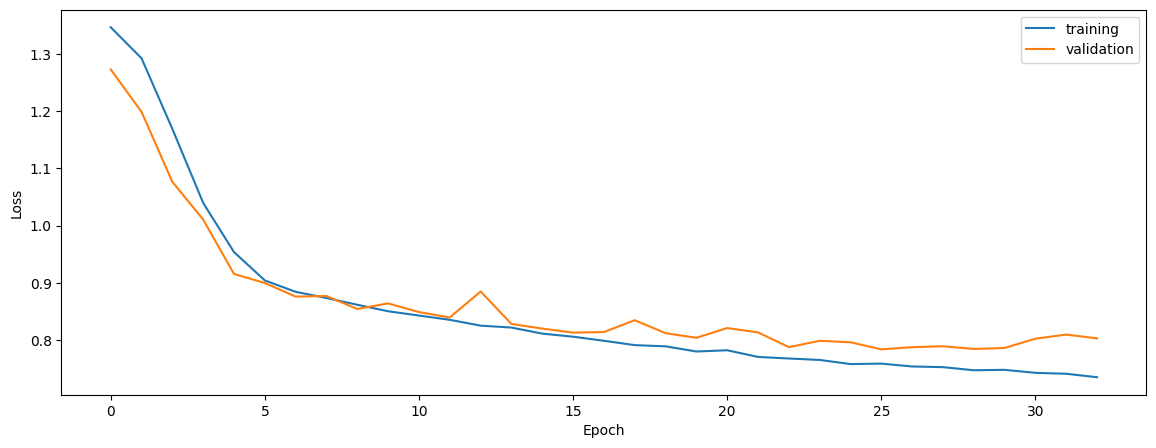

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6994049776801897
0.6993718394437421
0.703664752042715


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

normalized
0.6994049776801897
0.6993718394437421
0.703664752042715


In [9]:
print('native')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6976265174863069
0.7079350033852404
0.702589595119737


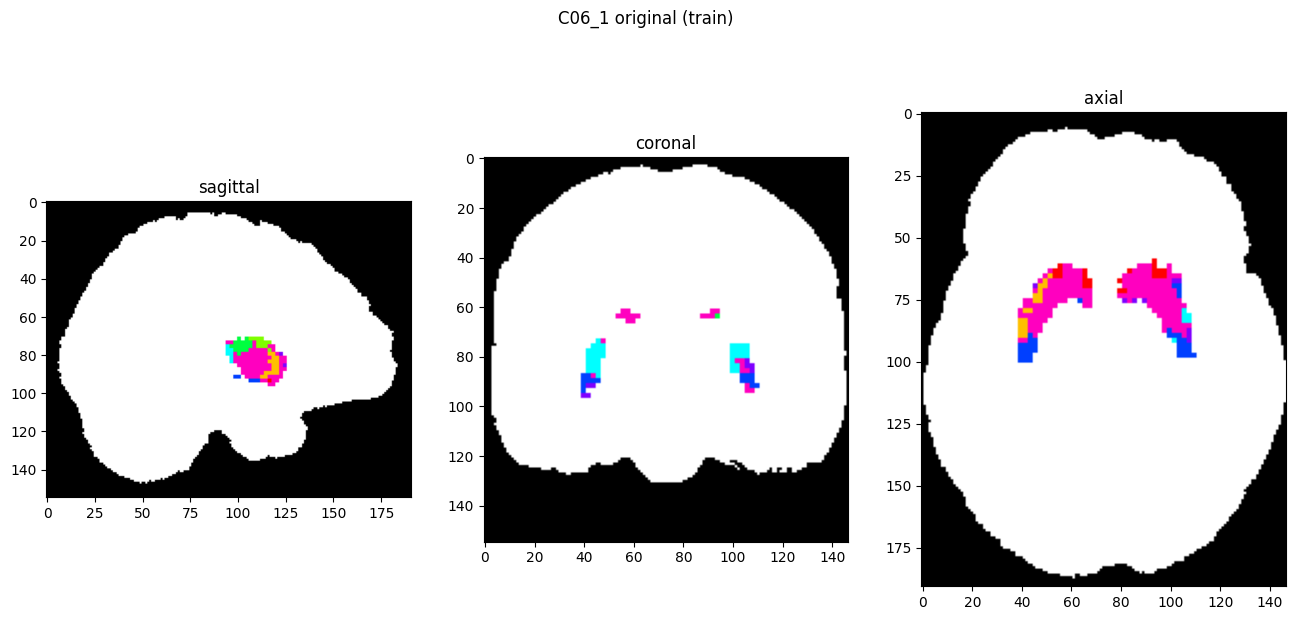

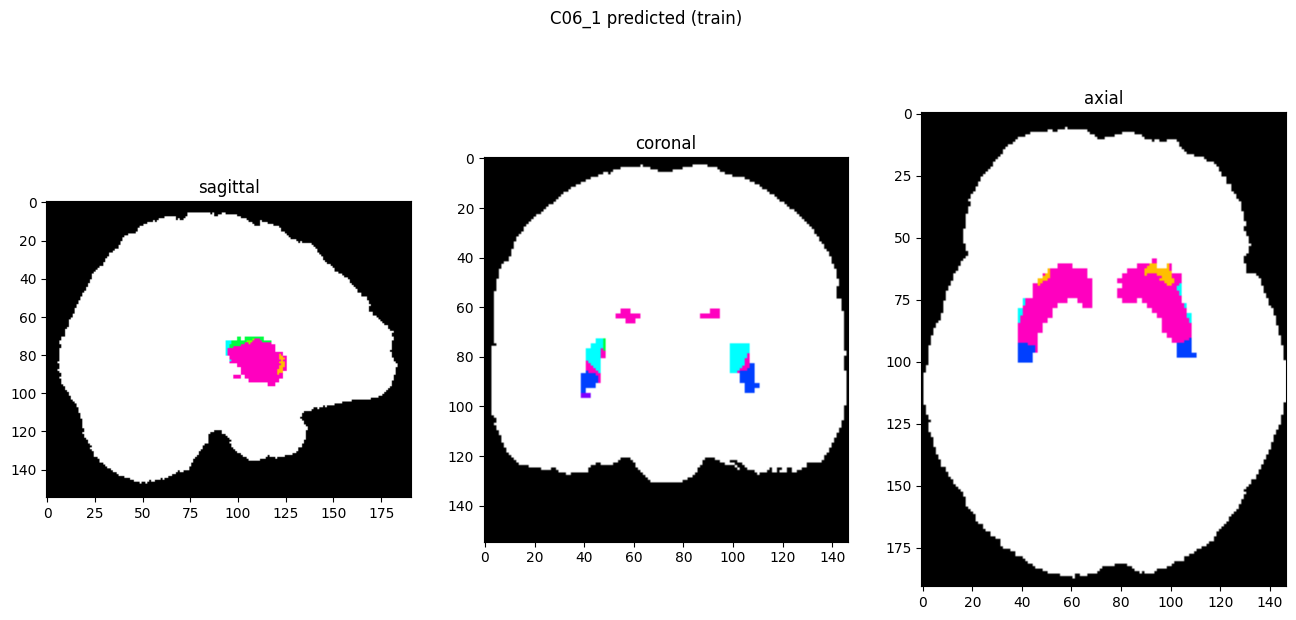

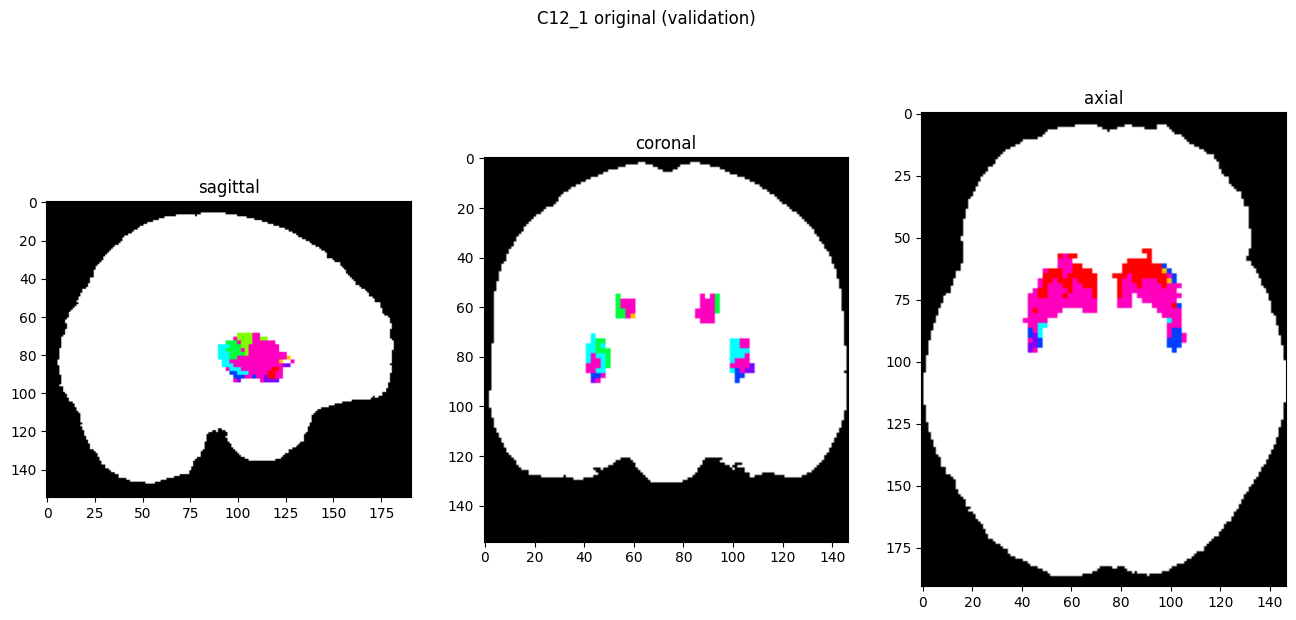

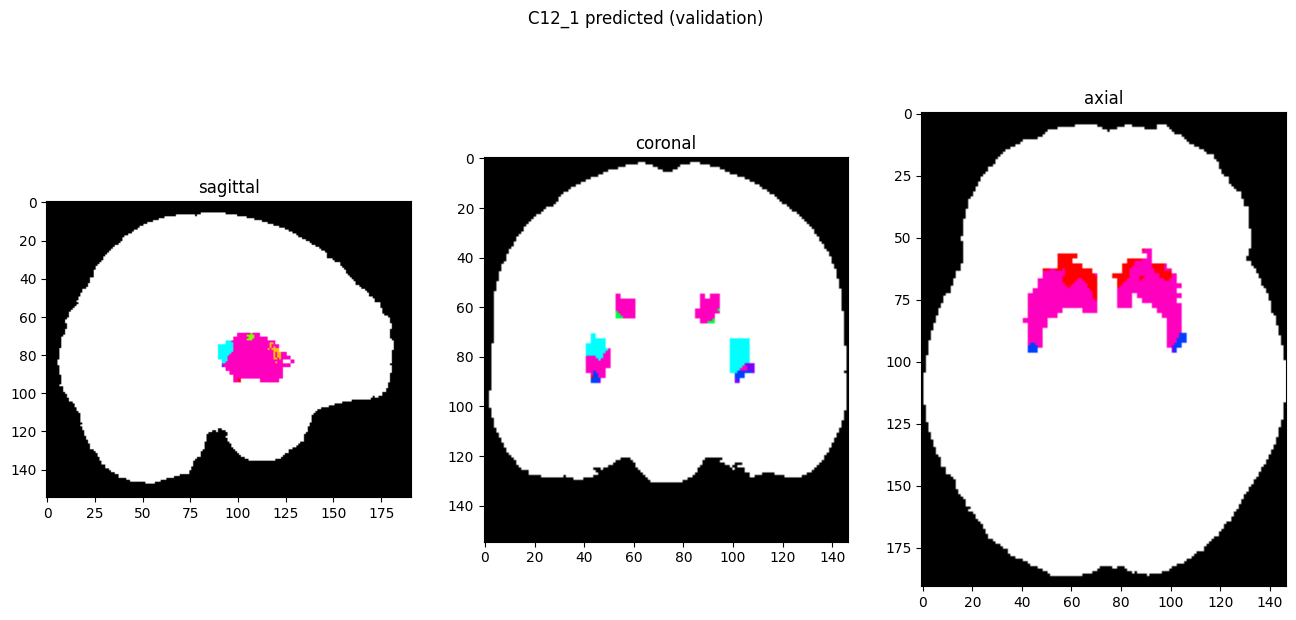

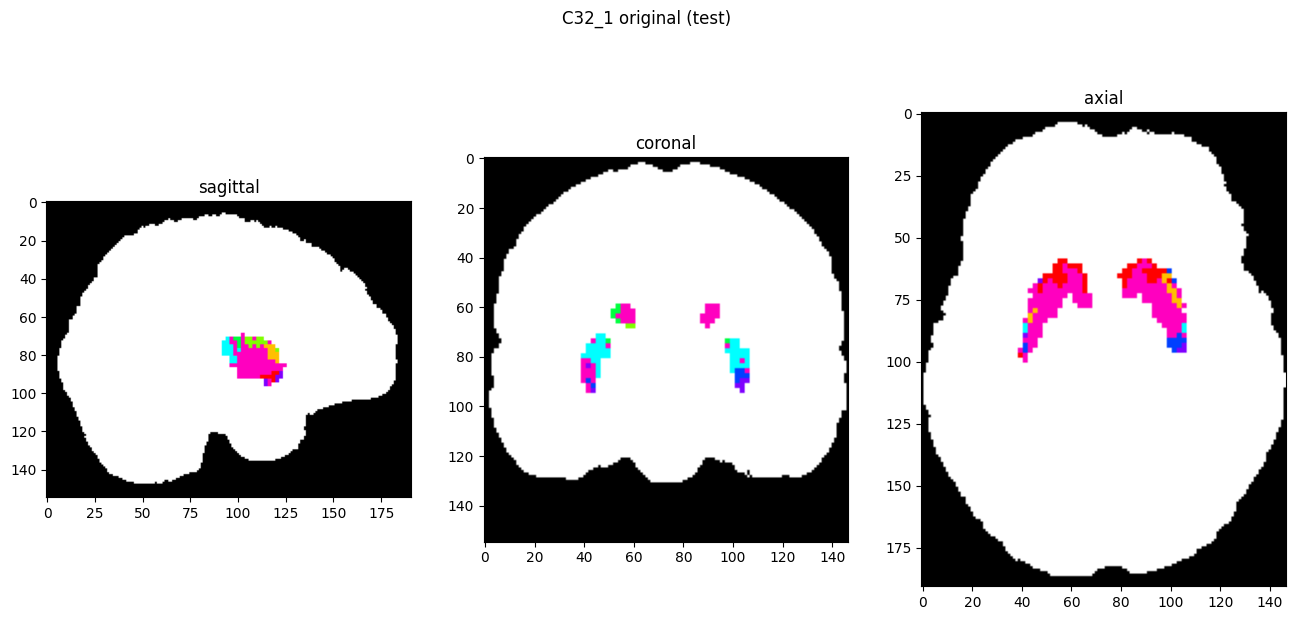

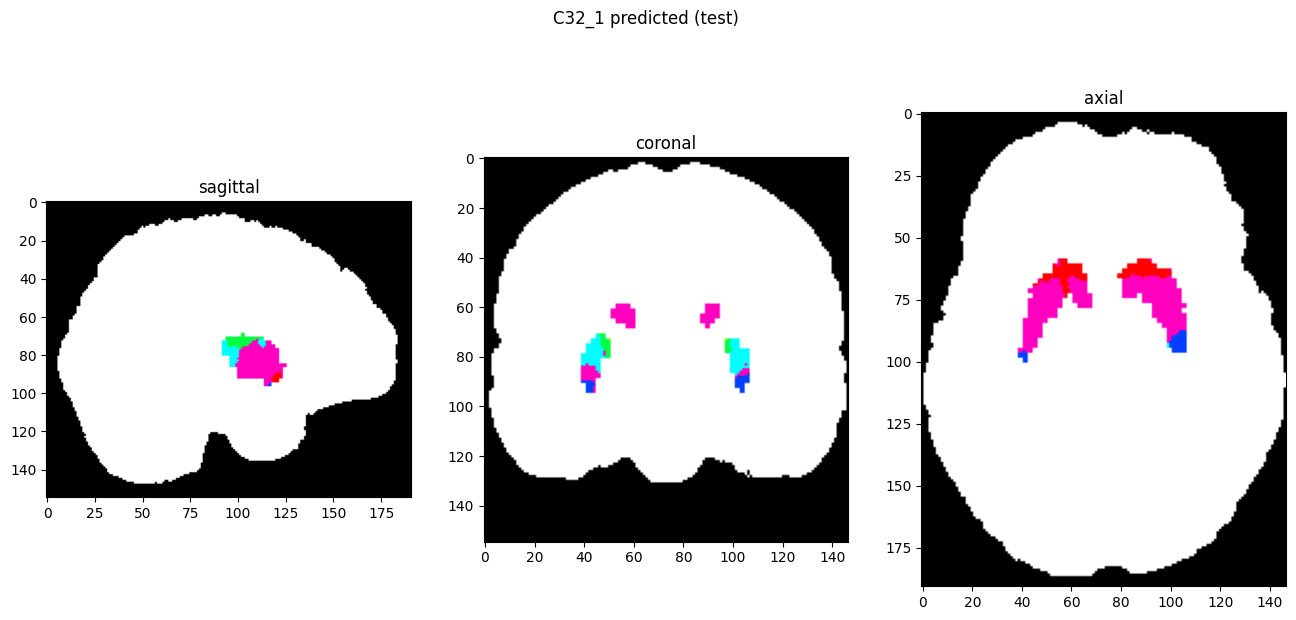

In [10]:
showResults(model, gen, threshold=0)